In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [4]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>

Создадим копии датасетов, с которыми будем работать, чтобы не менять исходники

In [5]:
train_df = train.copy()
test_df = test.copy()

Посмотрим какой объём оперативной памяти занимают датасеты:

In [6]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время.

Напишем функцию подсчёта объема занимаемой памяти:

In [7]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Все значения подтипов ```float``` в тип ```float```
2. ```object``` в ```category```

In [8]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [9]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



In [10]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].astype('category')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 924.3 MB


In [12]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].astype('category')

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2)
memory usage: 792.6 MB


In [14]:
print(f'train_df decreased on {100 - (memory_usage(train_df) * 100)/2567.094} %')
print(f'test_df decreased on {100 - (memory_usage(test_df) * 100)/2214.031} %')

train_df decreased on 63.989099234193674 %
test_df decreased on 64.19355467369698 %


Видим, что объём памяти, занимаемый каждым датасетом после преобразования типов признаков уменьшился примерно на ```64``` %

#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [15]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    len_df = len(df)
    mis_val_percent = 100 * mis_val / len_df
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

In [16]:
missing_values_table(train_df, 'train_df')

train_df has  434 columns.
 There are 414 columns that have missing values.


,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
...,...,...
V285,12,0.0
V284,12,0.0
V280,12,0.0
V279,12,0.0


In [17]:
missing_values_table(test_df, 'test_df')

test_df has  433 columns.
 There are 385 columns that have missing values.


,Missing Values,% of Total Values
id-24,501951,99.1
id-25,501652,99.0
id-26,501644,99.0
id-08,501632,99.0
id-07,501632,99.0
...,...,...
V293,3,0.0
C14,3,0.0
V319,3,0.0
V292,3,0.0


Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [18]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

In [19]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,C,13832,375.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173000,C,3154,408.0,185.0,mastercard,224.0,debit,...,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000000,W,16661,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удаляем признаки, в которых более ```50 %``` пропусков:

In [20]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 214 columns.


In [21]:
train_df = train_df.drop(columns = missing_columns)

In [22]:
train_df.shape

(590540, 220)

In [23]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 219)

Посмотрим ещё раз на пропуски 

In [24]:
miss_val_train_df = missing_values_table(train_df, 'train_df')
miss_val_train_df

train_df has  220 columns.
 There are 200 columns that have missing values.


,Missing Values,% of Total Values
M4,281444,47.7
D2,280797,47.5
V7,279287,47.3
V11,279287,47.3
V10,279287,47.3
...,...,...
V295,12,0.0
V297,12,0.0
V298,12,0.0
V299,12,0.0


In [25]:
missing_values_table(test_df, 'test_df')

test_df has  219 columns.
 There are 171 columns that have missing values.


,Missing Values,% of Total Values
M4,237745,46.9
D2,234769,46.3
D3,203142,40.1
M3,176639,34.9
M2,176639,34.9
...,...,...
V287,3,0.0
V290,3,0.0
V292,3,0.0
V293,3,0.0


И посмотрим насколько ещё уменьшился занимаемый объём памяти каждого из датасетов

In [26]:
print(f'train_df memory usage: {memory_usage(train_df)} Mb')
print(f'test_df memory usage: {memory_usage(test_df)} Mb')

train_df memory usage: 477.58735275268555 Mb
test_df memory usage: 409.29405784606934 Mb


### Разделим обучающую выборку на обучение и тест

Отделим данные от целевой переменной

In [27]:
X = train_df.drop(columns='isFraud')
y = train_df['isFraud']

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: uint8

Разделим обучающую выборку в процентном соотношении:
- train - ```70%```
- test - ```30%```

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3)

In [30]:
X_train.shape

(413378, 219)

In [31]:
y_train.shape

(413378,)

In [32]:
X_valid.shape

(177162, 219)

In [33]:
y_valid.shape

(177162,)

### Посмотрим на распределения признаков до заполнения пропусков

#### Посмотрим на распределение целевой переменной ```isFraud```

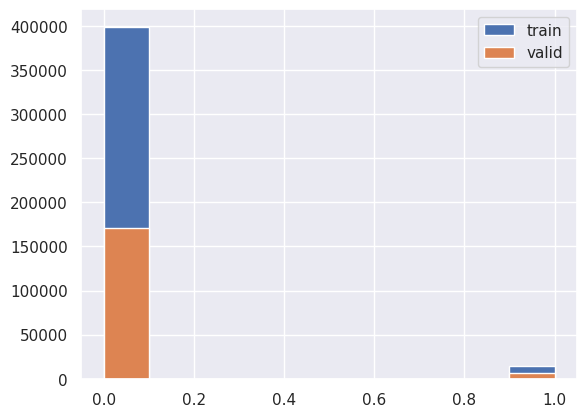

In [34]:
sns.set()
plt.hist(y_train, label='train')
plt.hist(y_valid, label='valid')
plt.legend()

In [35]:
isFraud_count = y_train.value_counts()
isFraud_prct = y_train.value_counts()/len(y_train)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,398914,0.96501
1,14464,0.03499


In [36]:
isFraud_count = y_valid.value_counts()
isFraud_prct = y_valid.value_counts()/len(y_valid)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,170963,0.965009
1,6199,0.034991


Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

Напишем функцию для построения распределений признаков

In [37]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[feature].value_counts().plot(kind='bar',
                                            figsize=(7,5),
                                            xlabel=title,
                                            ylabel='count',
                                            edgecolor='k',
                                            color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

#### Распределение ```Card 4``` (компания карты)

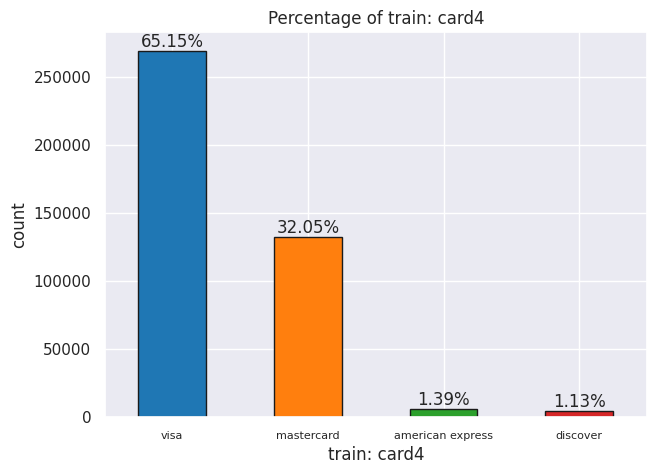

In [38]:
plot_value_counts('card4', 'train: card4', df=X_train)

Видим, что:

- ```65,34 %``` - карт компании 'visa'
- ```31,61 %``` - 'mastercard'
- ```1,68 %```  - 'american express'
- ```1,16 %```  - 'discover'

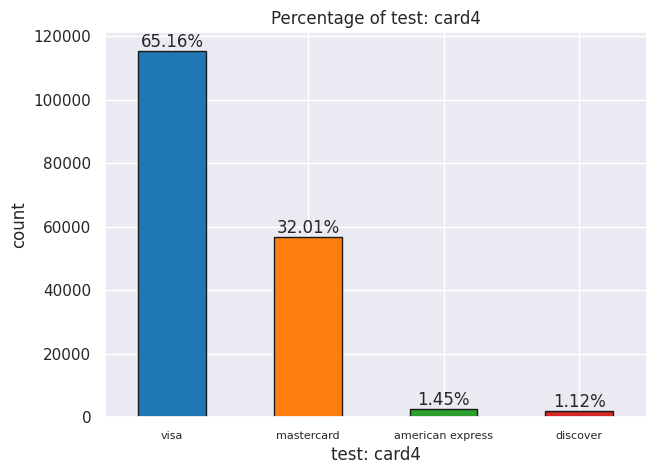

In [39]:
plot_value_counts('card4', 'test: card4', df=X_valid)

#### Распределение ```Card 6``` - тип карты

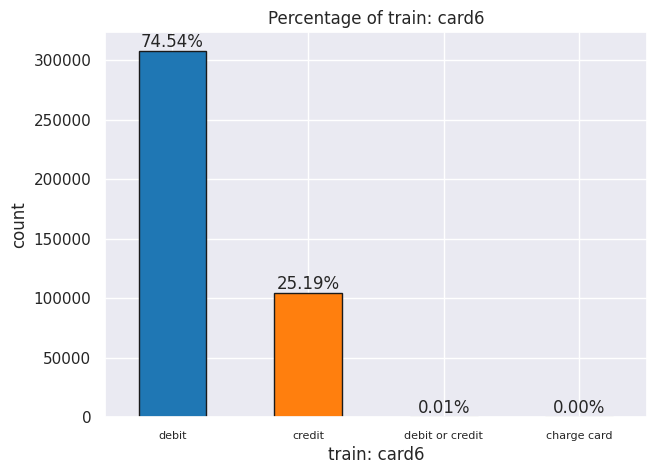

In [40]:
plot_value_counts('card6', 'train: card6', df=X_train)

Большая часть транзакций произведена дебетовыми картами - ```73,17 %```, ```26,61 %``` - кредитными картами. Транзакций с ```charge``` карт нет

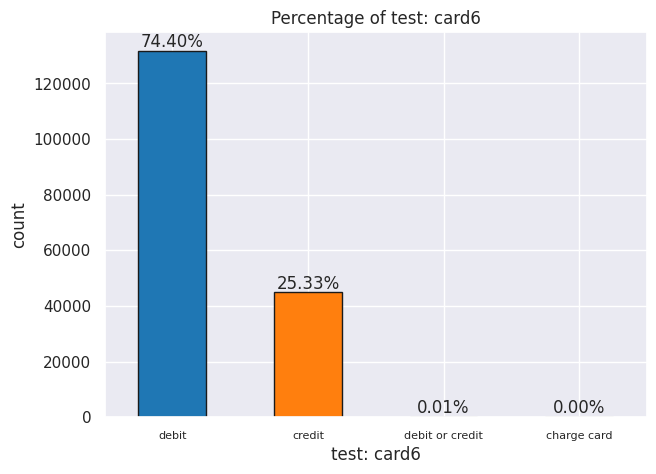

In [41]:
plot_value_counts('card6', 'test: card6', df=X_valid)

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [42]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df)
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

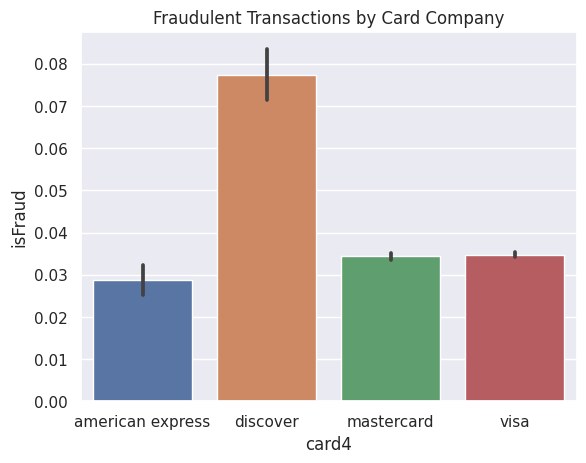

In [43]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

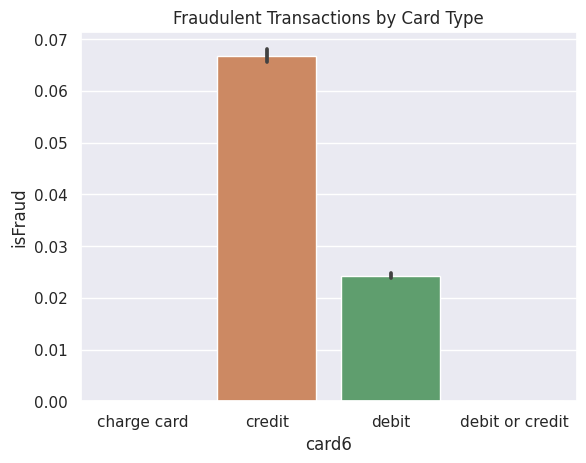

In [44]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

### Посмотрим, есть ли в данных дубликаты

In [45]:
X_train.duplicated().sum()

0

In [46]:
X_valid.duplicated().sum()

0

### Преобразуем категориальные признаки в числа

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 304425 to 80166
Columns: 219 entries, TransactionID to V321
dtypes: category(9), float32(207), uint16(1), uint32(2)
memory usage: 337.1 MB


In [48]:
for f in X_train.columns:
    if X_train.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_train.loc[:, f].values))
        X_train.loc[:, f] = le.transform(list(X_train.loc[:, f].values))

In [49]:
X_train

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
304425,3291425,7531146,78.500000,4,15497,490.0,150.0,4,226.0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
297919,3284919,7350270,39.000000,4,8135,247.0,150.0,4,226.0,1,...,93.0,141.000000,175.000000,141.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
521129,3508129,13698598,25.969999,4,9500,321.0,150.0,4,226.0,2,...,0.0,61.950001,61.950001,61.950001,0.000000,0.000000,0.000000,0.0,0.0,0.0
306940,3293940,7616691,54.136002,0,15257,375.0,185.0,2,224.0,2,...,0.0,39.514702,39.514702,39.514702,154.675201,154.675201,154.675201,0.0,0.0,0.0
111482,3098482,2170411,100.000000,2,17306,555.0,150.0,0,NaN,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72181,3059181,1617566,160.580002,4,15063,NaN,150.0,4,226.0,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
523945,3510945,13759421,87.949997,4,4067,445.0,150.0,2,224.0,2,...,0.0,0.000000,351.799988,87.949997,0.000000,0.000000,0.000000,0.0,0.0,0.0
529034,3516034,13912168,59.000000,4,1939,360.0,150.0,4,166.0,2,...,59.0,59.000000,59.000000,59.000000,205.000000,205.000000,205.000000,0.0,0.0,0.0
464598,3451598,11964817,57.950001,4,15986,360.0,150.0,2,229.0,2,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [50]:
for f in X_valid.columns:
    if X_valid.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_valid.loc[:, f].values))
        X_valid.loc[:, f] = le.transform(list(X_valid.loc[:, f].values))

In [51]:
X_valid

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
46589,3033589,1111747,20.351999,0,13413,103.0,185.0,4,137.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392434,3379434,9844907,226.000000,4,17188,321.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51673,3038673,1210247,58.182999,0,13413,103.0,185.0,4,137.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
512416,3499416,13401171,20.000000,1,14349,170.0,150.0,2,195.0,1,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
452500,3439500,11557712,117.000000,4,12695,490.0,150.0,4,226.0,2,...,106.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3540.5,737.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131786,3118786,2608022,59.480000,4,14661,210.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307735,3294735,7660857,87.000000,4,12695,490.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233592,3220592,5525341,25.950001,4,12839,321.0,150.0,4,226.0,2,...,0.0,0.0,35.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423709,3410709,10717166,87.949997,4,12695,490.0,150.0,4,226.0,2,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,C,13832,375.0,185.0,mastercard,224.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506687,4170236,34214287,12.173000,C,3154,408.0,185.0,mastercard,224.0,debit,...,0.000000,31.723700,31.723700,31.723700,0.0,0.0,0.0,0.0,0.0,0.0
506688,4170237,34214326,49.000000,W,16661,490.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506689,4170238,34214337,202.000000,W,16621,516.0,150.0,mastercard,224.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
for f in test_df.columns:
    if test_df.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(test_df.loc[:, f].values))
        test_df.loc[:, f] = le.transform(list(test_df.loc[:, f].values))

In [54]:
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,3663549,18403224,31.950001,4,10409,111.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,3663550,18403263,49.000000,4,4272,111.0,150.0,4,226.0,2,...,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3663551,18403310,171.000000,4,4476,574.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,3663552,18403310,284.950012,4,10989,360.0,150.0,4,166.0,2,...,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,3663553,18403317,67.949997,4,18018,452.0,150.0,2,117.0,2,...,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,0,13832,375.0,185.0,2,224.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506687,4170236,34214287,12.173000,0,3154,408.0,185.0,2,224.0,2,...,0.000000,31.723700,31.723700,31.723700,0.0,0.0,0.0,0.0,0.0,0.0
506688,4170237,34214326,49.000000,4,16661,490.0,150.0,4,226.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
506689,4170238,34214337,202.000000,4,16621,516.0,150.0,2,224.0,2,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Корреляция признаков

Выведем корреляции признаков в виде списка и отсортируем значения по убыванию. Отберём признаки с высокой корреляцией (>0.7)

In [55]:
df_corr = X_train.corr()

corrs = []
for feat1 in df_corr:
    for i, feat2 in enumerate(df_corr):
        corrs.append((feat1, feat2, df_corr[feat1].values[i]))
sorted_corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
max_sorted_corrs = [sort_tuple for sort_tuple in sorted_corrs \
                    if sort_tuple[0]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[1]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[-1] > 0.7 \
                    and sort_tuple[-1] < 1.0]
max_sorted_corrs[:30]

[('C7', 'C12', 0.9994964251421165),
 ('C1', 'C11', 0.9965524295663094),
 ('C1', 'C2', 0.9951088892399977),
 ('C2', 'C1', 0.9951088892399977),
 ('C2', 'C11', 0.9940137229719493),
 ('C6', 'C11', 0.9911592498442743),
 ('C7', 'C10', 0.9850241469495222),
 ('C6', 'C14', 0.9843445697790131),
 ('C7', 'C8', 0.9829856768161532),
 ('C1', 'C6', 0.9823509882263542),
 ('C6', 'C1', 0.9823509882263542),
 ('D1', 'D2', 0.9814202160489001),
 ('D2', 'D1', 0.9814202160489001),
 ('C2', 'C8', 0.9760051569729212),
 ('C2', 'C6', 0.9751140551519644),
 ('C6', 'C2', 0.9751140551519644),
 ('C2', 'C4', 0.9723672403017279),
 ('C2', 'C10', 0.9708429804067754),
 ('C1', 'C4', 0.9680964388707535),
 ('C1', 'C8', 0.9679968518579437),
 ('C6', 'C4', 0.9630723817875729),
 ('C1', 'C10', 0.9585153113211671),
 ('C1', 'C14', 0.9520982337027826),
 ('M2', 'M3', 0.9406057719737551),
 ('M3', 'M2', 0.9406057719737551),
 ('C2', 'C12', 0.9401867301191713),
 ('C2', 'C7', 0.9388187644971505),
 ('C7', 'C2', 0.9388187644971505),
 ('C2', 'C

Удалим признаки с высокой корреляцией (> 0.7)

In [56]:
max_sorted_corrs_feats1 = [tup[0] for tup in max_sorted_corrs]
max_sorted_corrs_feats2 = [tup[1] for tup in max_sorted_corrs]
max_sorted_corrs_feats = max_sorted_corrs_feats1 + max_sorted_corrs_feats2
set_max_sort_corrs_feats = set(max_sorted_corrs_feats)
print(len(max_sorted_corrs_feats1))
print(len(max_sorted_corrs_feats2))
print(len(max_sorted_corrs_feats))
print(len(set_max_sort_corrs_feats))
set_max_sort_corrs_feats

2640
2640
5280
198


{'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D15',
 'D2',
 'D4',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V2',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V279',
 'V28',
 'V280',
 'V282',
 'V283',
 'V284',
 'V285',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V3

In [57]:
X_train = X_train.drop(columns=list(set_max_sort_corrs_feats))
X_train

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
304425,3291425,7531146,78.500000,4,15497,490.0,4,226.0,2,299.0,...,2,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
297919,3284919,7350270,39.000000,4,8135,247.0,4,226.0,1,177.0,...,54,0.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
521129,3508129,13698598,25.969999,4,9500,321.0,4,226.0,2,204.0,...,16,0.0,15.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
306940,3293940,7616691,54.136002,0,15257,375.0,2,224.0,2,NaN,...,32,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
111482,3098482,2170411,100.000000,2,17306,555.0,0,NaN,1,299.0,...,54,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72181,3059181,1617566,160.580002,4,15063,NaN,4,226.0,1,110.0,...,16,0.0,49.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
523945,3510945,13759421,87.949997,4,4067,445.0,2,224.0,2,225.0,...,16,0.0,7.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
529034,3516034,13912168,59.000000,4,1939,360.0,4,166.0,2,330.0,...,16,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
464598,3451598,11964817,57.950001,4,15986,360.0,2,229.0,2,325.0,...,32,0.0,22.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [58]:
X_valid = X_valid.drop(columns=list(set_max_sort_corrs_feats))
X_valid

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
46589,3033589,1111747,20.351999,0,13413,103.0,4,137.0,1,130.0,...,19,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
392434,3379434,9844907,226.000000,4,17188,321.0,4,226.0,2,264.0,...,16,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
51673,3038673,1210247,58.182999,0,13413,103.0,4,137.0,1,NaN,...,19,0.0,190.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
512416,3499416,13401171,20.000000,1,14349,170.0,2,195.0,1,143.0,...,16,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
452500,3439500,11557712,117.000000,4,12695,490.0,4,226.0,2,325.0,...,16,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131786,3118786,2608022,59.480000,4,14661,210.0,4,226.0,2,343.0,...,23,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
307735,3294735,7660857,87.000000,4,12695,490.0,4,226.0,2,325.0,...,54,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
233592,3220592,5525341,25.950001,4,12839,321.0,4,226.0,2,264.0,...,16,0.0,9.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
423709,3410709,10717166,87.949997,4,12695,490.0,4,226.0,2,325.0,...,16,0.0,21.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


In [59]:
test_df = test_df.drop(columns=list(set_max_sort_corrs_feats))
test_df

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
0,3663549,18403224,31.950001,4,10409,111.0,4,226.0,2,170.0,...,16,0.0,27.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,3663550,18403263,49.000000,4,4272,111.0,4,226.0,2,299.0,...,2,0.0,7.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,3663551,18403310,171.000000,4,4476,574.0,4,226.0,2,472.0,...,19,0.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,3663552,18403310,284.950012,4,10989,360.0,4,166.0,2,205.0,...,16,0.0,41.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4,3663553,18403317,67.949997,4,18018,452.0,2,117.0,2,264.0,...,16,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679001,0,13832,375.0,2,224.0,2,284.0,...,16,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
506687,4170236,34214287,12.173000,0,3154,408.0,2,224.0,2,NaN,...,19,0.0,16.0,NaN,2.0,1.0,1.0,1.0,0.0,1.0
506688,4170237,34214326,49.000000,4,16661,490.0,4,226.0,2,327.0,...,19,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
506689,4170238,34214337,202.000000,4,16621,516.0,2,224.0,2,177.0,...,19,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0


Ещё раз проверим корреляцию признаков по карте корреляции

<Axes: >

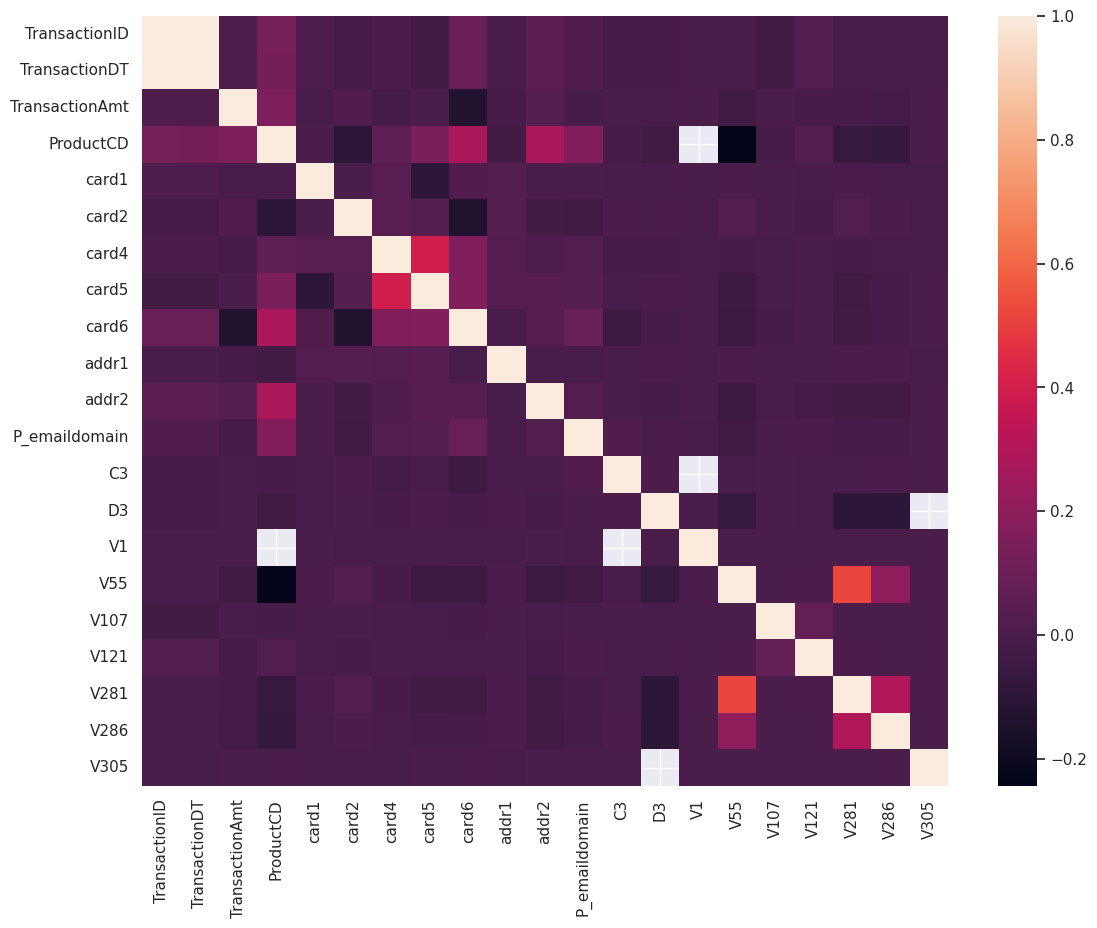

In [60]:
plt.figure(figsize=(13,10))
sns.heatmap(X_train.corr(), 
           xticklabels=X_train.columns, 
           yticklabels=X_train.columns)

Видим, что в датасете остались только слабо кореллированные признаки

### Посмотрим, есть ли в данных выбросы

Сперва отделим категориальные признаки от числовых

In [61]:
cat_feats = ['ProductCD', 'card1', 'card2', 'card4', 
             'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
num_feats = [x for x in X_train.columns if x not in cat_feats]
print(f'cat_feats:\n {cat_feats}\n')
print(f'num_feats:\n {num_feats}')

cat_feats:
 ['ProductCD', 'card1', 'card2', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']

num_feats:
 ['TransactionID', 'TransactionDT', 'TransactionAmt', 'C3', 'D3', 'V1', 'V55', 'V107', 'V121', 'V281', 'V286', 'V305']


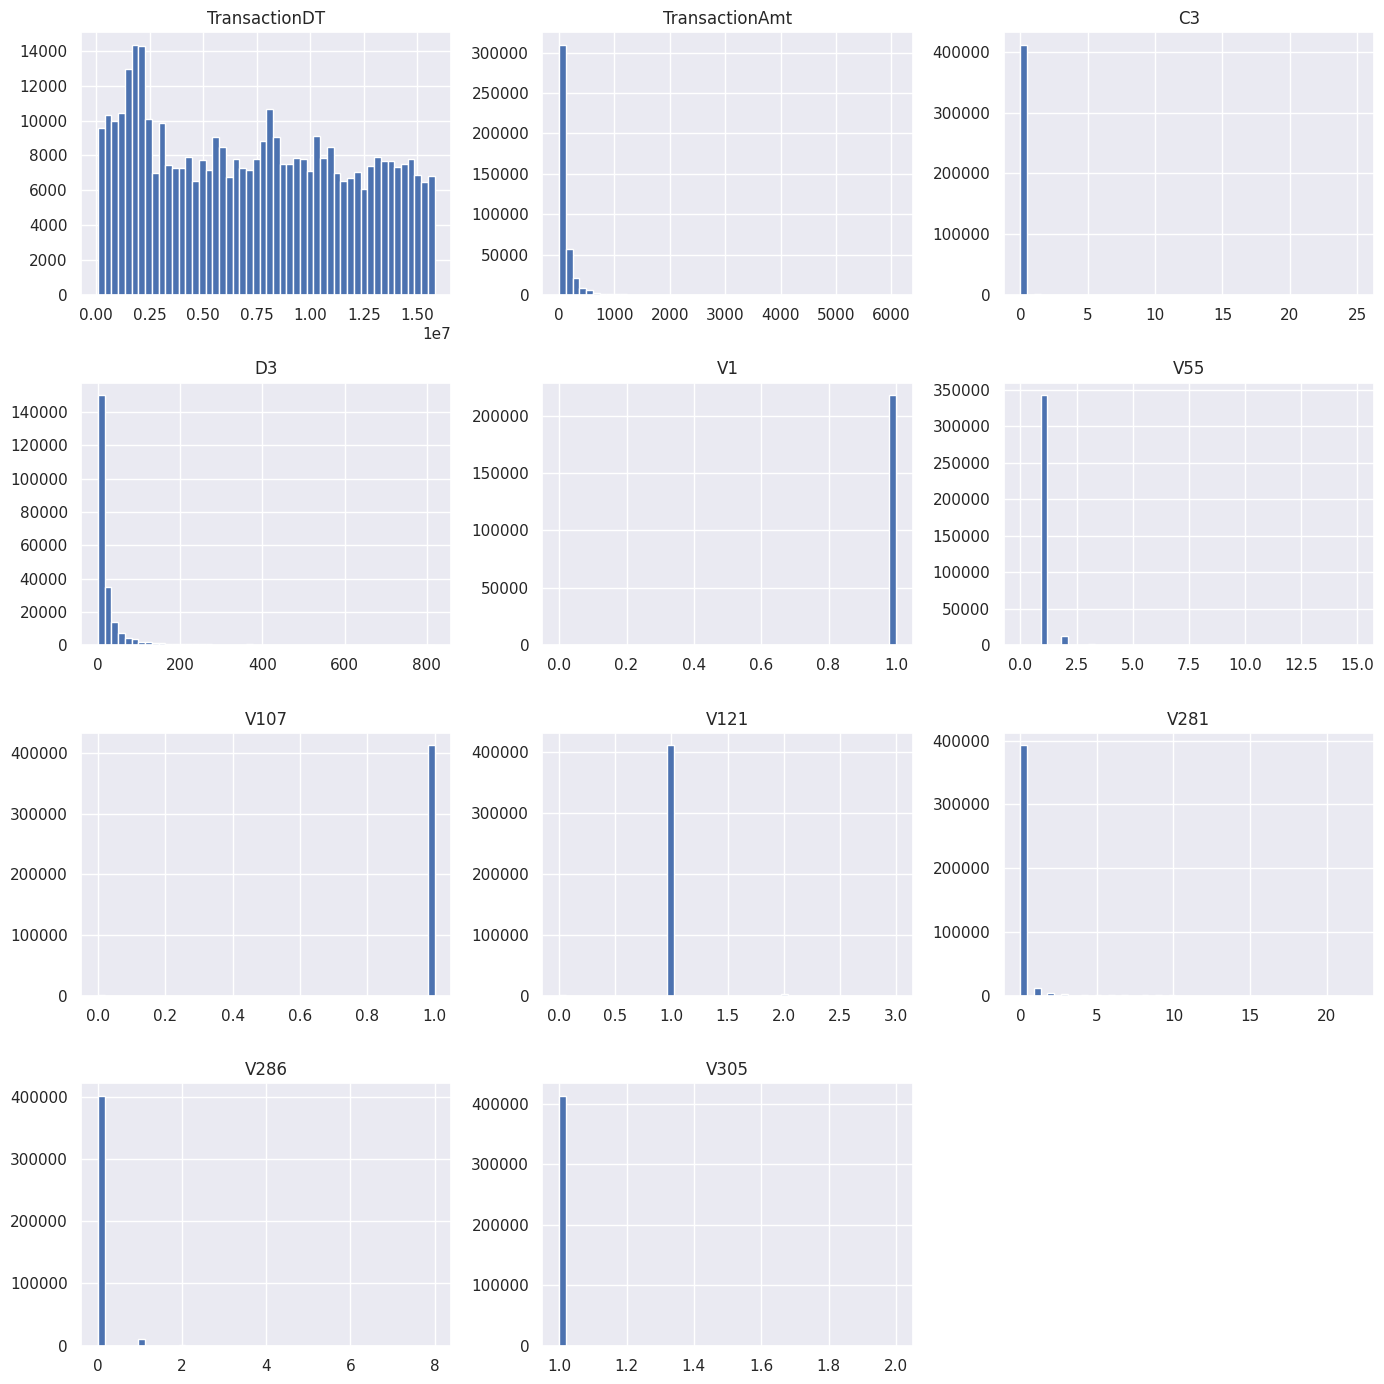

In [62]:
sns.set()
X_train[num_feats[1:]].hist(bins=50, figsize=(14,14))
plt.tight_layout()

Видим, что некоторые данные имеют выбросы. Посмотрим на графики ```boxplot```, чтобы явно убедиться в этом

In [63]:
def plt_boxplot(df, feature):
    sns.set()
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха {}'.format(feature))
    plt.xlabel(feature)
    plt.show()

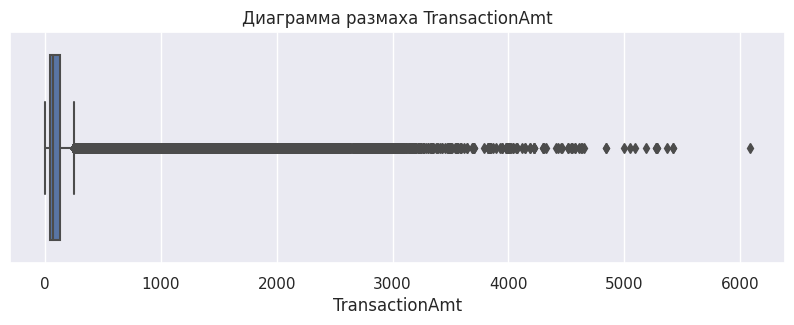

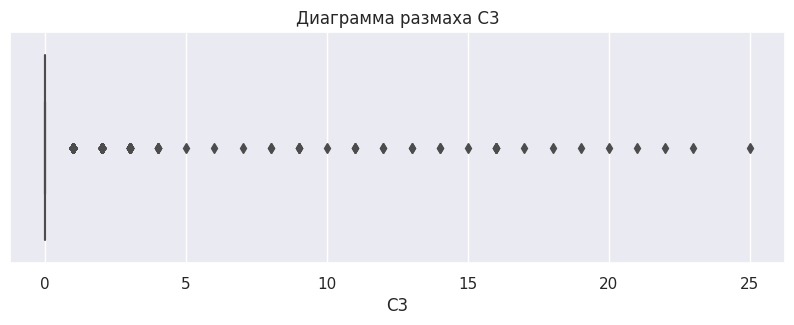

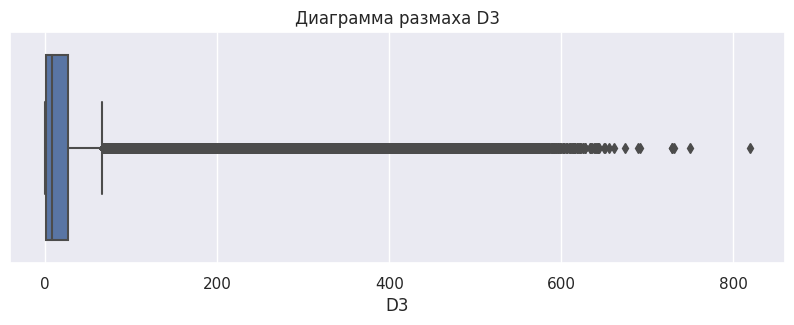

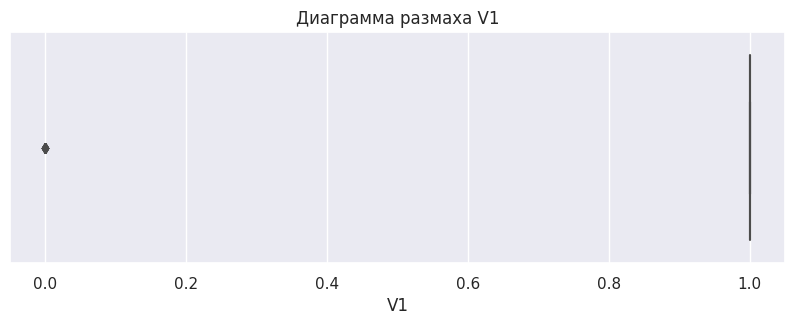

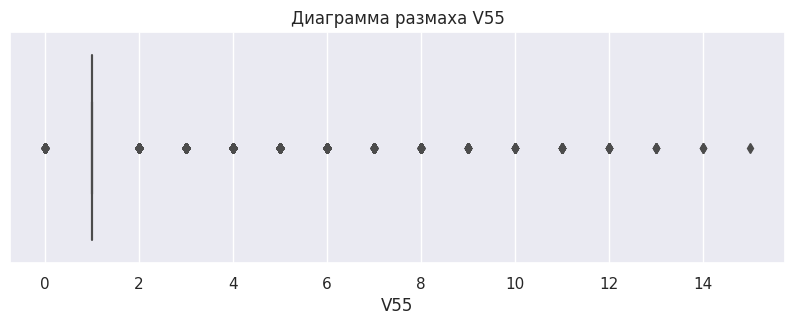

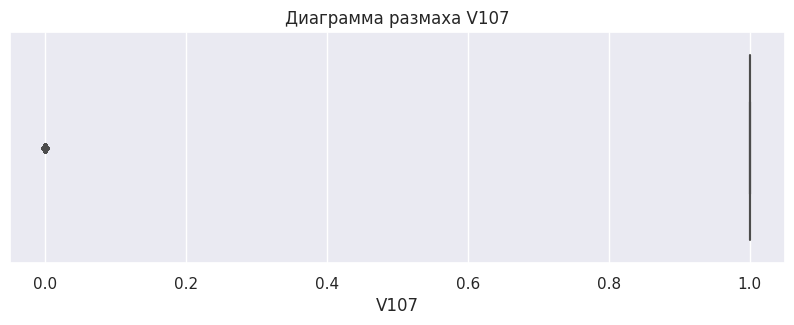

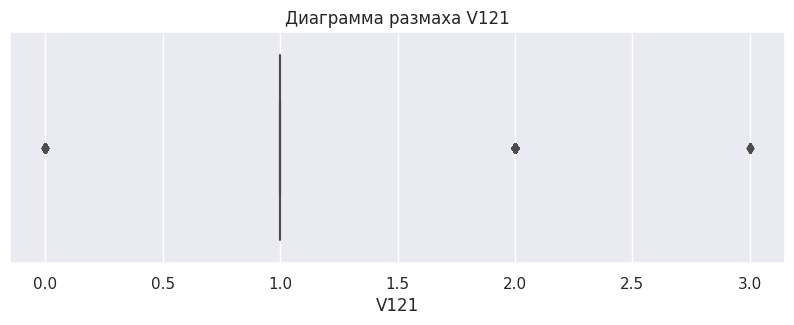

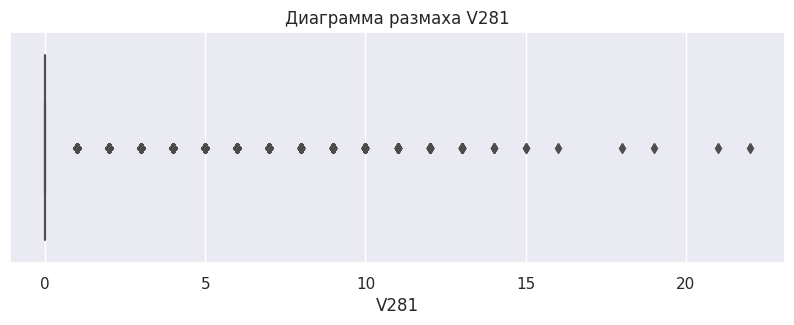

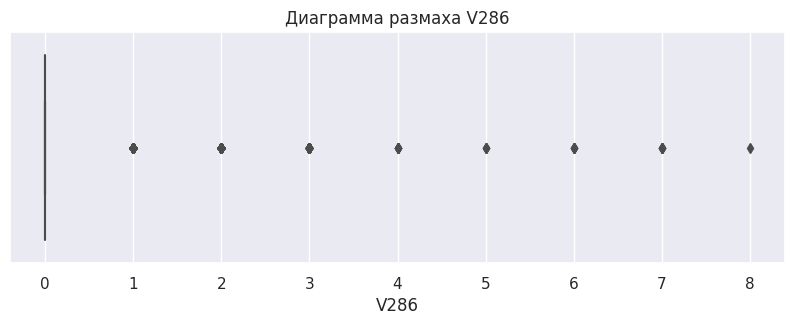

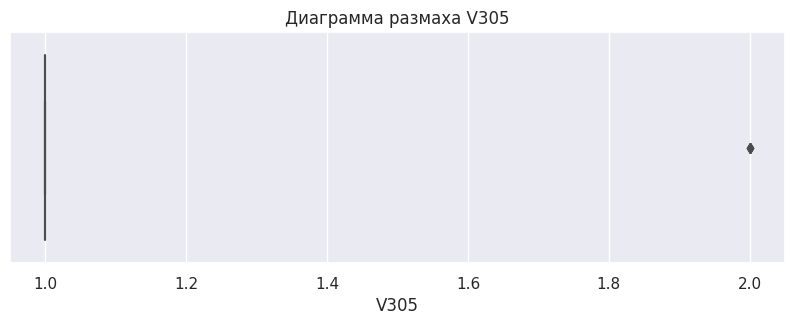

In [64]:
for feat in num_feats[2:]:
    plt_boxplot(X_train, feat)

Да, многие данные действительно имеют выбросы

### Посмотрим ещё раз на пропуски

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 304425 to 80166
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   413378 non-null  uint32 
 1   TransactionDT   413378 non-null  uint32 
 2   TransactionAmt  413378 non-null  float32
 3   ProductCD       413378 non-null  int64  
 4   card1           413378 non-null  uint16 
 5   card2           407104 non-null  float32
 6   card4           413378 non-null  int64  
 7   card5           410415 non-null  float32
 8   card6           413378 non-null  int64  
 9   addr1           367397 non-null  float32
 10  addr2           367397 non-null  float32
 11  P_emaildomain   413378 non-null  int64  
 12  C3              413378 non-null  float32
 13  D3              229455 non-null  float32
 14  V1              217962 non-null  float32
 15  V55             359592 non-null  float32
 16  V107            413140 non-null  float32
 17  V121       

In [66]:
X_train.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6274
card4                  0
card5               2963
card6                  0
addr1              45981
addr2              45981
P_emaildomain          0
C3                     0
D3                183923
V1                195416
V55                53786
V107                 238
V121                 238
V281                 878
V286                   8
V305                   8
dtype: int64

Сперва заполним пропуски числовых признаков средним по колонке

Сделаем копии датасетов, чтобы ничего не поменять в исходниках

In [67]:
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
test_df_copy = test_df.copy()

In [68]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [69]:
X_train_copy[num_feats] = X_train_copy[num_feats].fillna(
    X_train_copy[num_feats].mean())

In [70]:
X_valid_copy[num_feats] = X_valid_copy[num_feats].fillna(
    X_valid_copy[num_feats].mean())

In [71]:
test_df_copy[num_feats] = test_df_copy[num_feats].fillna(
    test_df_copy[num_feats].mean())

Пропуски в категориальных прихнаках заполним константой ```-1```

In [72]:
X_train_copy[cat_feats] = X_train_copy[cat_feats].fillna(-1)
X_valid_copy[cat_feats] = X_valid_copy[cat_feats].fillna(-1)
test_df_copy[cat_feats] = test_df_copy[cat_feats].fillna(-1)

Проверки, остались ли пропуски в данных после заполнения

In [73]:
X_train_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [74]:
X_valid_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [75]:
test_df_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### Посмотрим на распределения признаков после заполнения пропусков

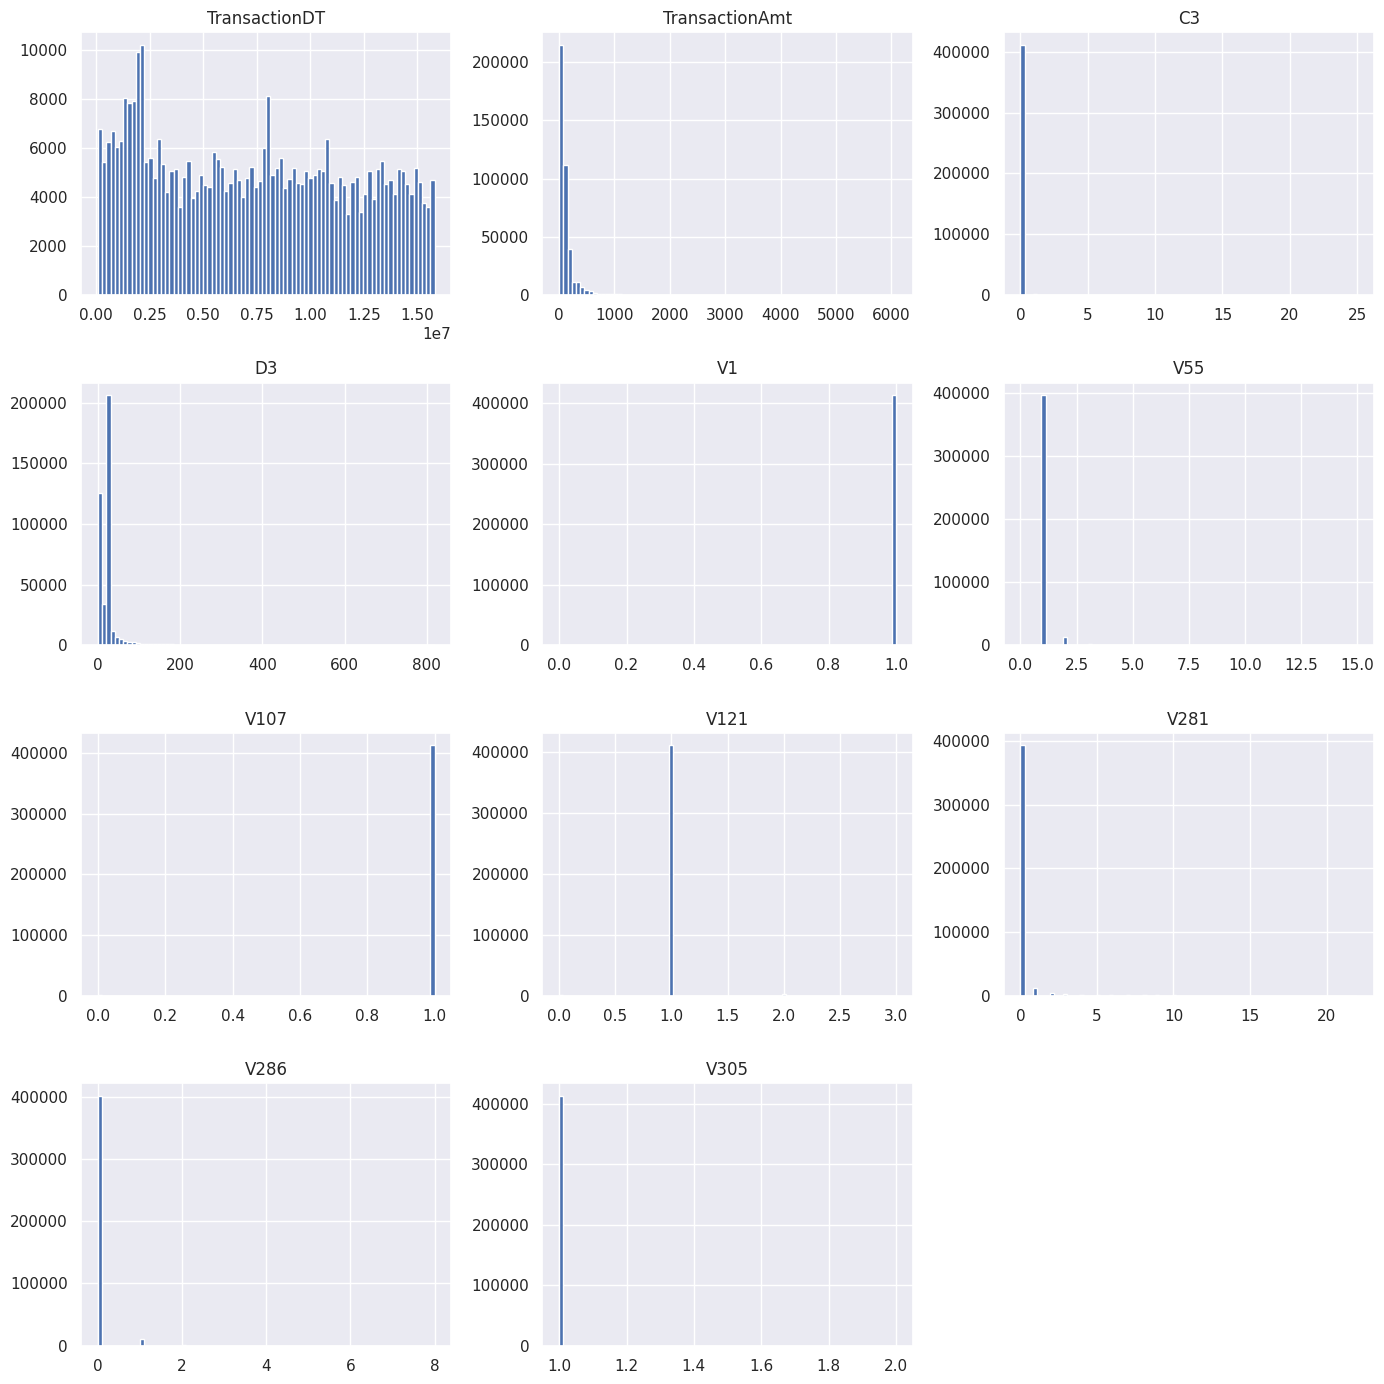

In [76]:
X_train_copy[num_feats[1:]].hist(bins=80, figsize=(14,14))
plt.tight_layout()

Видим, что распределения признаков после заполнения пропусков не изменились

#### Попробуем посмотреть на прогноз **логистической регрессии**

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
model_LR = LogisticRegression()

model_LR.fit(X_train_copy, y_train)

LogisticRegression()

In [79]:
y_pred_valid_LR = model_LR.predict(X_valid_copy)

In [80]:
y_pred_proba_valid_LR = model_LR.predict_proba(X_valid_copy)

In [81]:
y_pred_proba_valid_LR

array([[0.96739642, 0.03260358],
       [0.96407769, 0.03592231],
       [0.96740319, 0.03259681],
       ...,
       [0.96621461, 0.03378539],
       [0.96359794, 0.03640206],
       [0.9600537 , 0.0399463 ]])

In [82]:
y_pred_valid_LR

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [83]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


Отличный результат, но это на валидационной выборке, и плюс распределение ответов в нашей выборке не сбалансировано

#### Посмотрим на **матрицу ошибок**

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

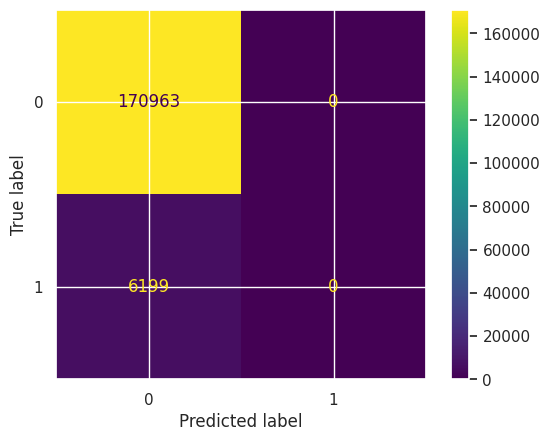

In [85]:
cm = confusion_matrix(y_valid, y_pred_valid_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Видим, что среди верных срабатываний не предсказано ни одного верного ответа

Посмотрим отчёт по метрикам классификации

In [86]:
print(classification_report(y_valid, y_pred_valid_LR))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Это потому что в данных большой дисбаланс классов

Так как размеры датасетов достаточно большие, уберём часть данных класса с большей долей (валидные) из нашей выборки

In [87]:
X_train_copy

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
304425,3291425,7531146,78.500000,4,15497,490.0,4,226.0,2,299.0,...,2,0.0,28.391161,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
297919,3284919,7350270,39.000000,4,8135,247.0,4,226.0,1,177.0,...,54,0.0,6.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
521129,3508129,13698598,25.969999,4,9500,321.0,4,226.0,2,204.0,...,16,0.0,15.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
306940,3293940,7616691,54.136002,0,15257,375.0,2,224.0,2,-1.0,...,32,0.0,0.000000,0.999945,1.000000,1.0,1.0,0.0,0.0,1.0
111482,3098482,2170411,100.000000,2,17306,555.0,0,-1.0,1,299.0,...,54,0.0,28.391161,0.999945,1.067054,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72181,3059181,1617566,160.580002,4,15063,-1.0,4,226.0,1,110.0,...,16,0.0,49.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
523945,3510945,13759421,87.949997,4,4067,445.0,2,224.0,2,225.0,...,16,0.0,7.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
529034,3516034,13912168,59.000000,4,1939,360.0,4,166.0,2,330.0,...,16,0.0,0.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
464598,3451598,11964817,57.950001,4,15986,360.0,2,229.0,2,325.0,...,32,0.0,22.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0


Мы помним, что распределение целевых меток в наших данных:
- валидные транзакции - ```96,5``` %
- мошеннические транзакции - ```3,5``` %

Попробуем убрать число копий мошеннических транзакций так, чтобы соотношение классов стало равным ```70```% (валидные) к ```30``` % (мошеннические)

Посчитаем сколько записей транзакций от **общего размера обучающей выборки** составляют ```70``` %:

In [88]:
num_y_train_70_prct = len(y_train) * 0.7
int(num_y_train_70_prct)

289364

Посмотрим сколько записей **валидных транзакций** надо удалить из обучающего датасета, чтобы соотношение долей ответов стало 70 к 30:

- num_trxs       - 100 %
- num_valid_trxs - 70 %
- num_fraud_trxs - 30%

In [89]:
not_fraud_trxs_count = len(y_train[y_train==0])
fraud_trxs_count = len(y_train[y_train==1])
# посмотрим какое общее число транзакций должно быть, 
# чтобы мы смогли достичь нужного соотношения
balanced_trxs_count = int(fraud_trxs_count * 100 / 30)
print('not_fraud_trxs_count: ', not_fraud_trxs_count)
print('fraud_trxs_count: ', fraud_trxs_count)
print('balanced_trxs_count: ', balanced_trxs_count)

not_fraud_trxs_count:  398914
fraud_trxs_count:  14464
balanced_trxs_count:  48213


Видим, что **сбалансированое кол-во транзакций было бы - 48213**, но мы не можем сократить число транзакций до такого кол-ва, т.к. данных останется слишком мало, что плохо скажется на прогнозах по тестовым данным

Поэтому необходимо **добавить** необходимое число копий **мошеннических транзакций** в датасеты

In [90]:
trxs_count = len(y_train)
opt_fraud_trxs_count = int(trxs_count * 30 / 100)
print('optimal fraud trxs count: ', opt_fraud_trxs_count)

optimal fraud trxs count:  124013


Посчитаем насколько копий нужно увеличить кол-во мошеннических записей

In [91]:
diff_fraud_trxs_count = opt_fraud_trxs_count - fraud_trxs_count
diff_fraud_trxs_count

109549

Нужно добавить **109549** записей класса 1

In [92]:
int(opt_fraud_trxs_count / fraud_trxs_count)

8

#### т.е. увеличим число мошеннических транзакций примерно в 8 раз

In [93]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(7)])
y_train_fraud_increased

528529    1
520258    1
578488    1
333344    1
204125    1
         ..
481000    1
3704      1
245       1
421535    1
338008    1
Name: isFraud, Length: 101248, dtype: uint8

In [94]:
y_train_increased = pd.concat([y_train, y_train_fraud_increased])
y_train_increased

304425    0
297919    0
521129    0
306940    0
111482    0
         ..
481000    1
3704      1
245       1
421535    1
338008    1
Name: isFraud, Length: 514626, dtype: uint8

Посмотрим теперь на соотношение ответов

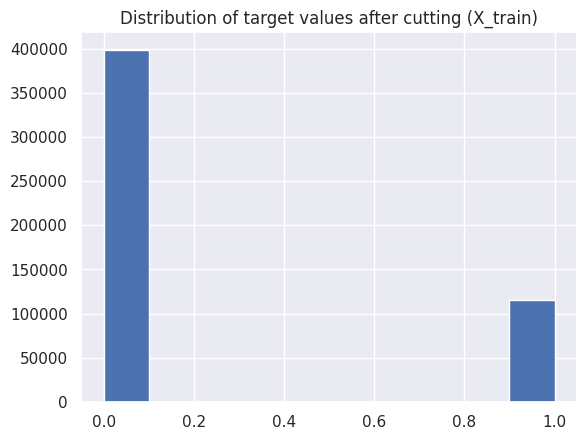

In [95]:
plt.hist(y_train_increased)
plt.title('Distribution of target values after cutting (X_train)')
plt.show()

Видим, как поменялось соотношение ответов

Увеличим кол-во соответствующих данных в датасете ```X_train```

In [96]:
before_inc = y_train[y_train==1].index
before_inc

Index([528529, 520258, 578488, 333344, 204125, 380191,  69686, 118339, 460927,
       416025,
       ...
       415852,  67443, 576286, 343905, 212143, 481000,   3704,    245, 421535,
       338008],
      dtype='int64', length=14464)

In [97]:
y_train_indexes = list(y_train_increased[y_train_increased==1].index[len(before_inc):])
len(y_train_indexes)

101248

In [98]:
X_train_increased = pd.concat([X_train, X_train.loc[y_train_indexes]])
X_train_increased

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
304425,3291425,7531146,78.500000,4,15497,490.0,4,226.0,2,299.0,...,2,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
297919,3284919,7350270,39.000000,4,8135,247.0,4,226.0,1,177.0,...,54,0.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
521129,3508129,13698598,25.969999,4,9500,321.0,4,226.0,2,204.0,...,16,0.0,15.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
306940,3293940,7616691,54.136002,0,15257,375.0,2,224.0,2,NaN,...,32,0.0,0.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
111482,3098482,2170411,100.000000,2,17306,555.0,0,NaN,1,299.0,...,54,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481000,3468000,12506241,117.000000,4,13249,111.0,4,226.0,2,498.0,...,54,0.0,173.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3704,2990704,158071,10.000000,3,8732,360.0,2,229.0,2,441.0,...,32,0.0,NaN,NaN,NaN,1.0,2.0,0.0,0.0,1.0
245,2987245,90295,37.098000,0,13413,103.0,4,137.0,1,NaN,...,19,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
421535,3408535,10682592,201.000000,4,12544,321.0,4,226.0,2,441.0,...,32,0.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0


In [99]:
y_train_increased.shape

(514626,)

In [100]:
X_train_increased.shape

(514626, 21)

In [101]:
X_train_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8255
card4                  0
card5               3950
card6                  0
addr1              83732
addr2              83732
P_emaildomain          0
C3                     0
D3                237767
V1                266627
V55                75710
V107                 336
V121                 336
V281                1088
V286                  15
V305                  15
dtype: int64

Снова заполним пропуски в данных:
- числовые признаки средними значениями по столбцам
- категориальные - ```-1```

In [102]:
X_train_increased[num_feats] = X_train_increased[num_feats].fillna(
    X_train_increased[num_feats].mean())

In [103]:
X_train_increased[cat_feats] = X_train_increased[cat_feats].fillna(-1)

In [104]:
X_train_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

### Проделаем вышеперечисленные действия с увеличением доли **мошеннических записей** для валидационного датасета

In [105]:
y_valid_fraud_increased = pd.concat([y_valid[y_valid==1] for i in range(7)])
y_valid_fraud_increased

452500    1
179151    1
279330    1
218788    1
138937    1
         ..
508166    1
295070    1
184406    1
17720     1
586645    1
Name: isFraud, Length: 43393, dtype: uint8

In [106]:
y_valid_increased = pd.concat([y_valid, y_valid_fraud_increased])
y_valid_increased

46589     0
392434    0
51673     0
512416    0
452500    1
         ..
508166    1
295070    1
184406    1
17720     1
586645    1
Name: isFraud, Length: 220555, dtype: uint8

Посмотрим на соотношение ответов валидационного датасета

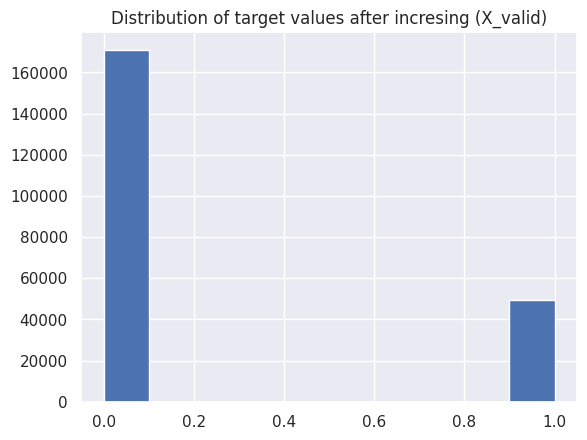

In [107]:
plt.hist(y_valid_increased)
plt.title('Distribution of target values after incresing (X_valid)')
plt.show()

In [108]:
before_inc = y_valid[y_valid==1].index
y_valid_indexes = list(y_valid_increased[y_valid_increased==1].index[len(before_inc):])
X_valid_increased = pd.concat([X_valid, X_valid.loc[y_valid_indexes]])
X_valid_increased

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,...,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
46589,3033589,1111747,20.351999,0,13413,103.0,4,137.0,1,130.0,...,19,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
392434,3379434,9844907,226.000000,4,17188,321.0,4,226.0,2,264.0,...,16,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0
51673,3038673,1210247,58.182999,0,13413,103.0,4,137.0,1,NaN,...,19,0.0,190.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
512416,3499416,13401171,20.000000,1,14349,170.0,2,195.0,1,143.0,...,16,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
452500,3439500,11557712,117.000000,4,12695,490.0,4,226.0,2,325.0,...,16,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508166,3495166,13304678,28.773001,0,3867,130.0,4,226.0,1,NaN,...,16,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,1.0
295070,3282070,7289535,56.794998,0,15885,545.0,4,138.0,2,NaN,...,16,0.0,0.0,NaN,2.0,1.0,1.0,1.0,1.0,1.0
184406,3171406,4087122,300.000000,1,17998,215.0,2,203.0,1,330.0,...,16,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,1.0
17720,3004720,485317,47.731998,0,4504,500.0,2,219.0,1,431.0,...,16,0.0,1.0,NaN,2.0,1.0,1.0,0.0,0.0,1.0


In [109]:
y_valid_increased.shape

(220555,)

In [110]:
X_valid_increased.shape

(220555, 21)

Заполним пропуски в валидационном датасете

In [111]:
X_valid_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               3639
card4                  0
card5               1779
card6                  0
addr1              36161
addr2              36161
P_emaildomain          0
C3                     0
D3                102419
V1                114559
V55                32949
V107                  97
V121                  97
V281                 503
V286                  11
V305                  11
dtype: int64

In [112]:
X_valid_increased[num_feats] = X_valid_increased[num_feats].fillna(
    X_valid_increased[num_feats].mean())

In [113]:
X_valid_increased[cat_feats] = X_valid_increased[cat_feats].fillna(-1)

In [114]:
X_valid_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### После добавления данных в датасеты посмотрим снова на прогноз модели логистической регрессии:

In [115]:
model_LR2 = LogisticRegression()
model_LR2.fit(X_train_increased, y_train_increased)

LogisticRegression()

In [116]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_increased)
y_pred_proba_valid_LR2 = model_LR2.predict_proba(X_valid_increased)

In [117]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid_increased).sum()/len(y_valid_increased)}')

Доля верно угаданных объектов 0.7751490557910725


Видим, что качество прогнозов ухудшилось. Посмотрим на матрицу ошибок и отчёт классификации

Напишем функцию для построения матрицы ошибок:

In [118]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

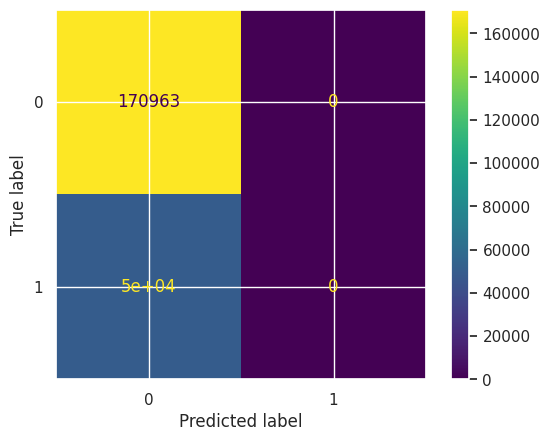

In [119]:
conf_matrix(y_valid_increased, y_pred_valid_LR2)

In [120]:
print(classification_report(y_valid_increased, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87    170963
           1       0.00      0.00      0.00     49592

    accuracy                           0.78    220555
   macro avg       0.39      0.50      0.44    220555
weighted avg       0.60      0.78      0.68    220555



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Попробуем сделать прогноз на исходной выборке ```X_valid_copy``` с дисбалансом в данных

In [121]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_copy)
y_pred_proba_valid_LR2 = model_LR2.predict_proba(X_valid_copy)

In [122]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


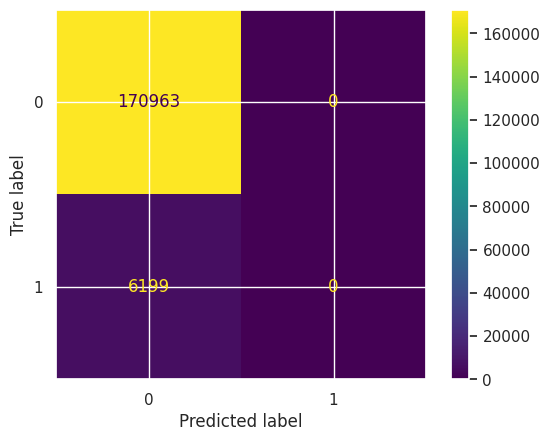

In [123]:
conf_matrix(y_valid, y_pred_valid_LR2)

In [124]:
print(classification_report(y_valid, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Видим, что среди верных срабатываний доля верно предсказанных значений мошеннических транзакций увеличилась, но число ошибок также очень большое

#### Но попробуем сбалансировать значения двух выборок 50 на 50. Уменьшим кол-во записей в датасете с классом 0

In [125]:
opt_fraud_trxs_count

124013

In [126]:
not_fraud_trxs_count

398914

In [127]:
balanced_y_train_0 = y_train[y_train==0][:opt_fraud_trxs_count]
balanced_y_train_0

304425    0
297919    0
521129    0
306940    0
111482    0
         ..
232153    0
163905    0
500622    0
16891     0
556384    0
Name: isFraud, Length: 124013, dtype: uint8

In [128]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(8)])
y_train_fraud_increased

528529    1
520258    1
578488    1
333344    1
204125    1
         ..
481000    1
3704      1
245       1
421535    1
338008    1
Name: isFraud, Length: 115712, dtype: uint8

In [129]:
y_train_balanced = pd.concat([balanced_y_train_0, y_train_fraud_increased])
y_train_balanced

304425    0
297919    0
521129    0
306940    0
111482    0
         ..
481000    1
3704      1
245       1
421535    1
338008    1
Name: isFraud, Length: 239725, dtype: uint8

Посмотрим теперь на соотношение ответов

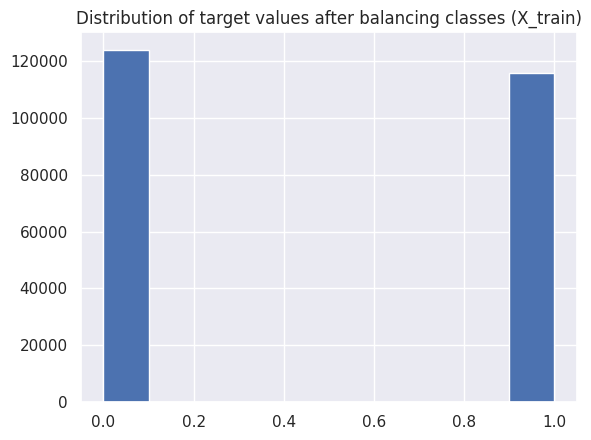

In [130]:
plt.hist(y_train_balanced)
plt.title('Distribution of target values after balancing classes (X_train)')
plt.show()

In [131]:
y_train_balanced.shape

(239725,)

In [132]:
X_train_balanced = X_train_copy.loc[y_train_balanced.index]

In [133]:
X_train_balanced.shape

(239725, 21)

In [134]:
test_df.shape

(506691, 21)

In [135]:
model_LR4 = LogisticRegression()
model_LR4.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [136]:
y_pred_valid_LR4 = model_LR4.predict(X_valid_copy)

In [137]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR4 == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7699224438649371


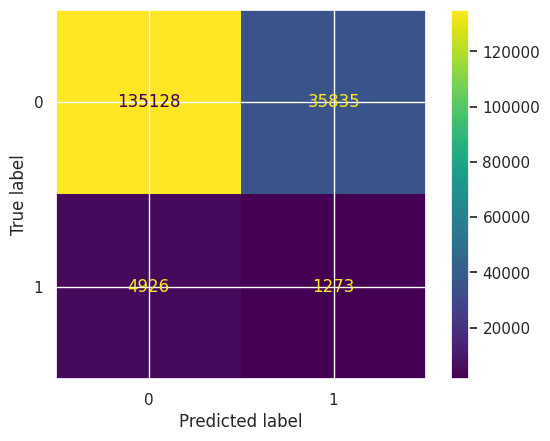

In [138]:
conf_matrix(y_valid, y_pred_valid_LR4)

In [139]:
print(classification_report(y_valid, y_pred_valid_LR4))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87    170963
           1       0.03      0.21      0.06      6199

    accuracy                           0.77    177162
   macro avg       0.50      0.50      0.46    177162
weighted avg       0.93      0.77      0.84    177162



Видим, что качество после уравнивания долей ответов обоих классов по прежнему остаётся не очень хорошим, хоть и полнота для класса 1 выросла

#### Так как линейные модели чувствительны к порядкам признаков, необходимо произвести **масштабирование признаков**

In [140]:
from sklearn.preprocessing import StandardScaler

Уберём из датасета признак ```TransactionID```

In [141]:
X_train_balanced2 = X_train_balanced.drop(columns=['TransactionID'])
X_train_balanced2

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
304425,7531146,78.500000,4,15497,490.0,4,226.0,2,299.0,87.0,2,0.0,28.391161,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
297919,7350270,39.000000,4,8135,247.0,4,226.0,1,177.0,87.0,54,0.0,6.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
521129,13698598,25.969999,4,9500,321.0,4,226.0,2,204.0,87.0,16,0.0,15.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
306940,7616691,54.136002,0,15257,375.0,2,224.0,2,-1.0,-1.0,32,0.0,0.000000,0.999945,1.000000,1.0,1.0,0.0,0.0,1.0
111482,2170411,100.000000,2,17306,555.0,0,-1.0,1,299.0,87.0,54,0.0,28.391161,0.999945,1.067054,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481000,12506241,117.000000,4,13249,111.0,4,226.0,2,498.0,87.0,54,0.0,173.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
3704,158071,10.000000,3,8732,360.0,2,229.0,2,441.0,87.0,32,0.0,28.391161,0.999945,1.067054,1.0,2.0,0.0,0.0,1.0
245,90295,37.098000,0,13413,103.0,4,137.0,1,-1.0,-1.0,19,0.0,28.391161,0.999945,1.000000,1.0,1.0,0.0,0.0,1.0
421535,10682592,201.000000,4,12544,321.0,4,226.0,2,441.0,87.0,32,0.0,1.000000,1.000000,1.000000,1.0,1.0,2.0,0.0,1.0


In [142]:
X_valid_copy2 = X_valid_copy.drop(columns=['TransactionID'])
X_valid_copy2

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
46589,1111747,20.351999,0,13413,103.0,4,137.0,1,130.0,60.0,19,0.0,28.231632,0.999946,1.000000,1.0,1.0,0.0,0.0,1.0
392434,9844907,226.000000,4,17188,321.0,4,226.0,2,264.0,87.0,16,0.0,28.231632,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
51673,1210247,58.182999,0,13413,103.0,4,137.0,1,-1.0,-1.0,19,0.0,190.000000,0.999946,1.000000,1.0,1.0,0.0,0.0,1.0
512416,13401171,20.000000,1,14349,170.0,2,195.0,1,143.0,87.0,16,0.0,28.231632,0.999946,1.069112,1.0,1.0,0.0,0.0,1.0
452500,11557712,117.000000,4,12695,490.0,4,226.0,2,325.0,87.0,16,0.0,0.000000,1.000000,1.000000,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131786,2608022,59.480000,4,14661,210.0,4,226.0,2,343.0,87.0,23,0.0,28.231632,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
307735,7660857,87.000000,4,12695,490.0,4,226.0,2,325.0,87.0,54,0.0,28.231632,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
233592,5525341,25.950001,4,12839,321.0,4,226.0,2,264.0,87.0,16,0.0,9.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0
423709,10717166,87.949997,4,12695,490.0,4,226.0,2,325.0,87.0,16,0.0,21.000000,1.000000,1.000000,1.0,1.0,0.0,0.0,1.0


In [143]:
scaler = StandardScaler()
scaler.fit(X_train_balanced2, y_train_balanced)
X_train_sc = pd.DataFrame(scaler.transform(X_train_balanced2), 
                          index=X_train_balanced2.index,
                          columns=X_train_balanced2.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid_copy2), 
                         index=X_valid_copy2.index,
                         columns=X_valid_copy2.columns)

Построим лог. регрессию на новых данных

In [144]:
model_LR_sc = LogisticRegression()
model_LR_sc.fit(X_train_sc, y_train_balanced)
y_pred_valid_LR_sc = model_LR_sc.predict(X_valid_sc)
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_sc == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.7652826226843228


Видим, что доля верно угаданных ответов немного выросла

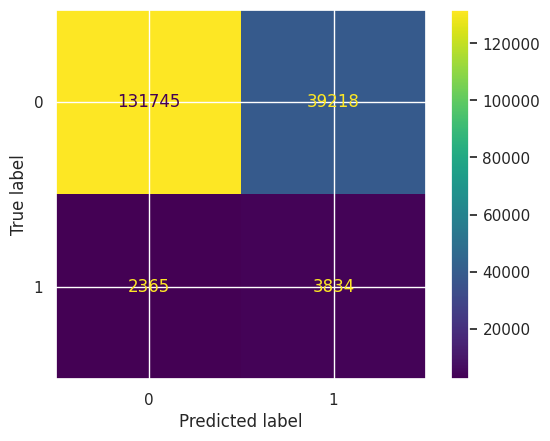

In [145]:
conf_matrix(y_valid, y_pred_valid_LR_sc)

In [146]:
print(classification_report(y_valid, y_pred_valid_LR_sc))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.62      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.69      0.51    177162
weighted avg       0.95      0.77      0.84    177162



#### По матрице ошибок и отчёту классификации видно, что полнота предсказаных значений класса ```1``` **значительно выросла**

#### Теперь попробуем убрать шум в данных при помощи **метода главных компонент**

In [147]:
X_train_sc

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,C3,D3,V1,V55,V107,V121,V281,V286,V305
304425,0.001557,-0.272043,0.760398,1.192517,0.805496,0.713384,0.675672,0.720111,0.491376,0.558409,-1.409805,-0.028569,0.092514,0.012563,-0.239422,0.016487,-0.076125,-0.230213,-0.171012,-0.002043
297919,-0.038356,-0.440896,0.760398,-0.326406,-0.674456,0.713384,0.675672,-1.312608,-0.307087,0.558409,1.961594,-0.028569,-0.470653,0.012563,-0.239422,0.016487,-0.076125,-0.230213,-0.171012,-0.002043
521129,1.362474,-0.496597,0.760398,-0.044780,-0.223771,0.713384,0.675672,0.720111,-0.130378,0.558409,-0.502121,-0.028569,-0.244291,0.012563,-0.239422,0.016487,-0.076125,-0.230213,-0.171012,-0.002043
306940,0.020433,-0.376194,-1.550051,1.143001,0.105107,-1.200821,0.633008,0.720111,-1.472057,-1.811638,0.535233,-0.028569,-0.621560,-0.003006,-0.239422,0.016487,-0.076125,-0.230213,-0.171012,-0.002043
111482,-1.181349,-0.180136,-0.394827,1.565749,1.201368,-3.115026,-4.166697,-1.312608,0.491376,0.558409,1.961594,-0.028569,0.092514,-0.003006,-0.088734,0.016487,-0.076125,-0.230213,-0.171012,-0.002043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481000,1.099367,-0.107465,0.760398,0.728711,-1.502742,0.713384,0.675672,0.720111,1.793786,0.558409,1.961594,-0.028569,3.729610,0.012563,-0.239422,0.016487,-0.076125,-0.230213,-0.171012,-0.002043
3704,-1.625395,-0.564865,0.182785,-0.203234,0.013752,-1.200821,0.739669,0.720111,1.420733,0.558409,0.535233,-0.028569,0.092514,-0.003006,-0.088734,0.016487,12.273252,-0.230213,-0.171012,-0.002043
245,-1.640350,-0.449027,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-1.472057,-1.811638,-0.307617,-0.028569,0.092514,-0.003006,-0.239422,0.016487,-0.076125,-0.230213,-0.171012,-0.002043
421535,0.696958,0.251616,0.760398,0.583256,-0.223771,0.713384,0.675672,0.720111,1.420733,0.558409,0.535233,-0.028569,-0.596409,0.012563,-0.239422,0.016487,-0.076125,2.334212,-0.171012,-0.002043


In [148]:
from sklearn import decomposition

In [149]:
pca = decomposition.PCA()
pca.fit(X_train_sc)
X_train_norm = pca.transform(X_train_sc)
X_valid_norm = pca.transform(X_valid_sc)

Посмотрим, как выглядит вклад каждой из компонент в разброс исходных данных

In [150]:
pca.explained_variance_ratio_

array([0.14641094, 0.08126278, 0.06782774, 0.058676  , 0.05268384,
       0.05147863, 0.05037078, 0.05007263, 0.04997828, 0.04979711,
       0.04832108, 0.04780181, 0.04636284, 0.04453333, 0.04376935,
       0.0349925 , 0.03153188, 0.02441686, 0.01471361, 0.00499802])

Видим, что большая часть компонент вносит примерно равный вклад в разброс исходных данных, поэтому будем обучать модель с использованием всех компонент

In [151]:
model_LR_norm = LogisticRegression()
model_LR_norm.fit(X_train_norm, y_train_balanced)

LogisticRegression()

In [152]:
y_pred_valid_LR_norm = model_LR_norm.predict(X_valid_norm)

In [153]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_norm == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7652826226843228


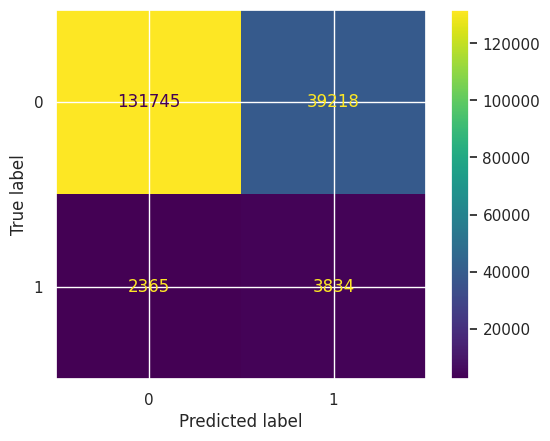

In [154]:
conf_matrix(y_valid, y_pred_valid_LR_norm)

In [155]:
print(classification_report(y_valid, y_pred_valid_LR_norm))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.62      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.69      0.51    177162
weighted avg       0.95      0.77      0.84    177162



### Попробуем сделать прогнозы с использованием других, более сложных моделей

Напишем функцию, которая будет обучать модели, делать прогнозы и предоставлять отчёт по качеству прогнозов

In [156]:
def fit_pred_score(model, model_name, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    print('------------------------------')
    print(model_name)
    print(f'Доля верно угаданных объектов {(y_pred == y_valid).sum() / len(y_valid)}')
    conf_matrix(y_valid, y_pred)
    print(classification_report(y_valid, y_pred))
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    print('roc auc score: ', roc_auc_score(y_valid, y_pred_proba))
    return model, roc_auc

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9311534076156286


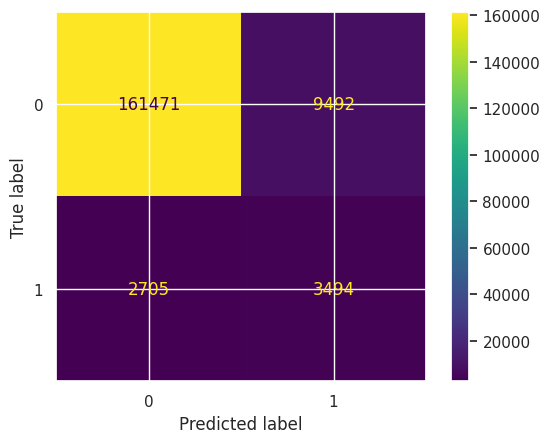

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.27      0.56      0.36      6199

    accuracy                           0.93    177162
   macro avg       0.63      0.75      0.66    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7540592557308076


In [157]:
DTmodel, DT_roc_auc_score = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
RandomForest
Доля верно угаданных объектов 0.9666181235253609


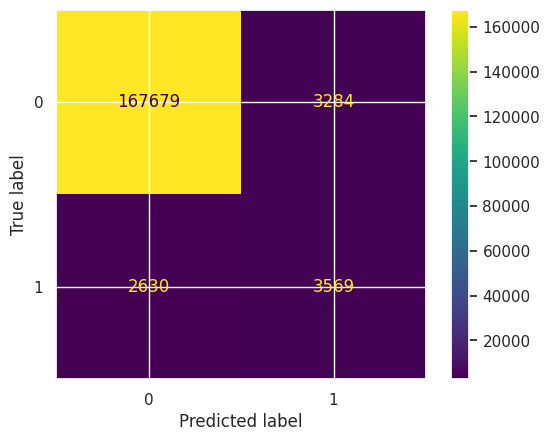

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.52      0.58      0.55      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.78      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9067901365019999


In [158]:
RFmodel, RF_roc_auc_score = fit_pred_score(RandomForestClassifier(), 'RandomForest', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7643004707555796


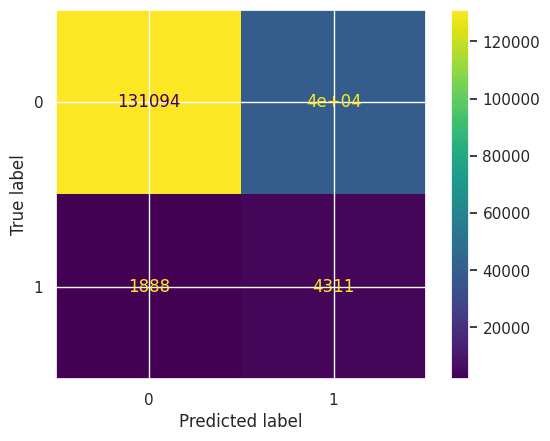

              precision    recall  f1-score   support

           0       0.99      0.77      0.86    170963
           1       0.10      0.70      0.17      6199

    accuracy                           0.76    177162
   macro avg       0.54      0.73      0.52    177162
weighted avg       0.95      0.76      0.84    177162

roc auc score:  0.8070505080763676


In [159]:
AdaBoost_model, AdaBoost_roc_auc_score = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
GradientBoosting
Доля верно угаданных объектов 0.775070274663867


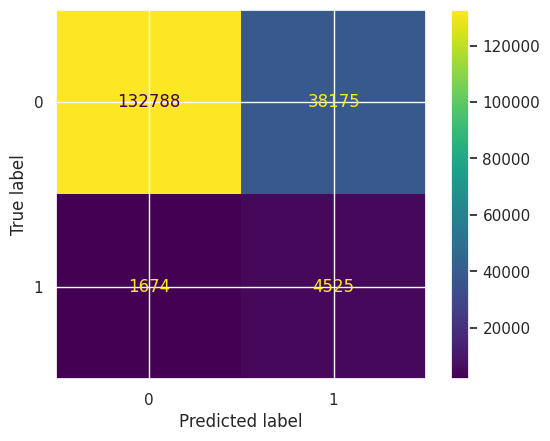

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.11      0.73      0.19      6199

    accuracy                           0.78    177162
   macro avg       0.55      0.75      0.53    177162
weighted avg       0.96      0.78      0.85    177162

roc auc score:  0.8314391812723371


In [160]:
GBM_model, GBM_roc_auc_score = fit_pred_score(GradientBoostingClassifier(), 'GradientBoosting', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8580395344374075


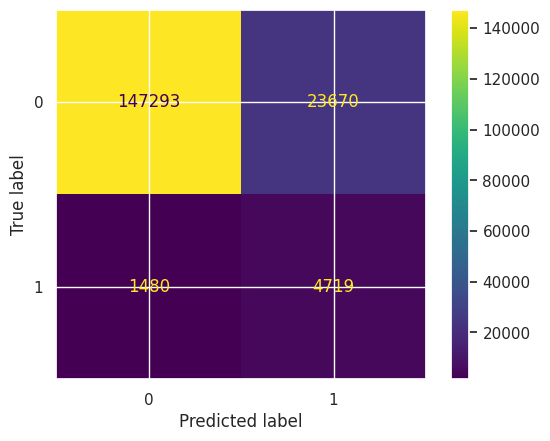

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    170963
           1       0.17      0.76      0.27      6199

    accuracy                           0.86    177162
   macro avg       0.58      0.81      0.60    177162
weighted avg       0.96      0.86      0.90    177162

roc auc score:  0.8906144921617858


In [161]:
XGB_model, XGB_roc_auc_score = fit_pred_score(XGBClassifier(), 'XGB', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8227046432079114


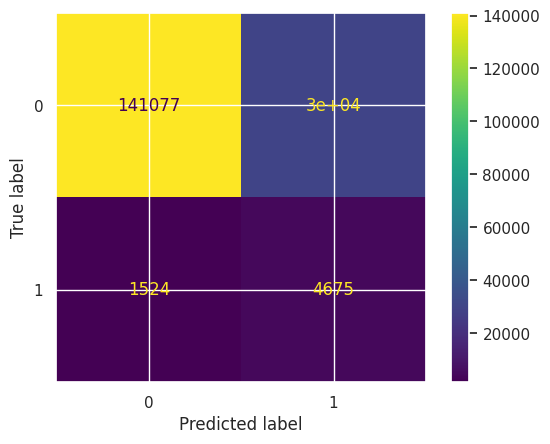

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    170963
           1       0.14      0.75      0.23      6199

    accuracy                           0.82    177162
   macro avg       0.56      0.79      0.56    177162
weighted avg       0.96      0.82      0.88    177162

roc auc score:  0.868807169632952


In [162]:
LGBM_model, LGBM_roc_auc_score = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

Сделаем общую таблицу по основной метрике качества этого задания ```roc auc score```, чтобы наглядно увидеть лучшую модель:

In [163]:
roc_auc_df = pd.DataFrame(data=[DT_roc_auc_score, 
                                RF_roc_auc_score,
                                AdaBoost_roc_auc_score,
                                GBM_roc_auc_score,
                                XGB_roc_auc_score,
                                LGBM_roc_auc_score],
                          index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                         columns=['roc auc score'])
roc_auc_df

,roc auc score
DT,0.754059
RF,0.906790
AdaBoost,0.807051
GBM,0.831439
XGB,0.890614
LGBM,0.868807


### Видим, что классфикатор ```Random Forest``` показал наилучшую точность

#### Посмотрим на важность признаков:

In [164]:
print('DecesionTree important features:')
sorted(zip(X_train_sc.columns, DTmodel.feature_importances_), key=lambda x: -x[1])

DecesionTree important features:


[('TransactionDT', 0.19682696221723478),
 ('TransactionAmt', 0.1422680094530968),
 ('addr2', 0.11101664156944764),
 ('card1', 0.10944570456783484),
 ('D3', 0.07816981984973989),
 ('addr1', 0.0754801870989672),
 ('card2', 0.07546353771604196),
 ('P_emaildomain', 0.06049487352297998),
 ('V55', 0.05316583471788054),
 ('card5', 0.026158809982927453),
 ('V281', 0.01727918898239021),
 ('card6', 0.015920619259964155),
 ('ProductCD', 0.012310088123215055),
 ('card4', 0.00989313719331713),
 ('V1', 0.0077947476900965115),
 ('V286', 0.0043586330042817345),
 ('C3', 0.0026416708245958595),
 ('V121', 0.001085326313126605),
 ('V107', 0.00022620791286149923),
 ('V305', 0.0)]

In [165]:
print('RandomForest important features:')
sorted(zip(X_train_sc.columns, RFmodel.feature_importances_), key=lambda x: -x[1])

RandomForest important features:


[('TransactionDT', 0.16717219775377282),
 ('TransactionAmt', 0.14706060773285332),
 ('addr1', 0.10947527755462538),
 ('card1', 0.10165905784724422),
 ('D3', 0.08661713222940384),
 ('card2', 0.07863664527223717),
 ('P_emaildomain', 0.06799842928053741),
 ('ProductCD', 0.051093212734462844),
 ('addr2', 0.0339085320261574),
 ('card5', 0.033011129153607155),
 ('card6', 0.029832168991474988),
 ('V55', 0.026695198609283644),
 ('V281', 0.026276068443677414),
 ('V1', 0.018083542650426103),
 ('card4', 0.012764548637767518),
 ('V286', 0.005648356922492559),
 ('V121', 0.001980950584441843),
 ('C3', 0.0018341609933059918),
 ('V107', 0.0002482444593277745),
 ('V305', 4.538122900502242e-06)]

In [166]:
print('AdaBoost important features:')
sorted(zip(X_train_sc.columns, AdaBoost_model.feature_importances_), key=lambda x: -x[1])

AdaBoost important features:


[('P_emaildomain', 0.2),
 ('TransactionAmt', 0.12),
 ('V55', 0.12),
 ('card2', 0.1),
 ('card1', 0.08),
 ('D3', 0.08),
 ('TransactionDT', 0.06),
 ('ProductCD', 0.04),
 ('card4', 0.04),
 ('V281', 0.04),
 ('card6', 0.02),
 ('addr2', 0.02),
 ('C3', 0.02),
 ('V1', 0.02),
 ('V121', 0.02),
 ('V286', 0.02),
 ('card5', 0.0),
 ('addr1', 0.0),
 ('V107', 0.0),
 ('V305', 0.0)]

In [167]:
print('GradientBoosting important features:')
sorted(zip(X_train_sc.columns, GBM_model.feature_importances_), key=lambda x: -x[1])

GradientBoosting important features:


[('ProductCD', 0.195341762716202),
 ('D3', 0.16872557834688892),
 ('addr2', 0.15518366629809613),
 ('TransactionAmt', 0.09704010991980831),
 ('card6', 0.07192012209498912),
 ('TransactionDT', 0.07113462125945656),
 ('V55', 0.06437998954436924),
 ('P_emaildomain', 0.04891448390187749),
 ('V281', 0.03816567070749508),
 ('card2', 0.024067484518785893),
 ('card1', 0.02256596500112347),
 ('addr1', 0.018568255559297614),
 ('V286', 0.006707894474784825),
 ('C3', 0.005229474563712392),
 ('card4', 0.004753592765067248),
 ('card5', 0.004152432607161265),
 ('V121', 0.0018938353004834796),
 ('V1', 0.0012550604204008592),
 ('V107', 0.0),
 ('V305', 0.0)]

In [168]:
print('XGB important features:')
sorted(zip(X_train_sc.columns, XGB_model.feature_importances_), key=lambda x: -x[1])

XGB important features:


[('addr2', 0.50467885),
 ('V55', 0.07424733),
 ('ProductCD', 0.0729798),
 ('D3', 0.04535414),
 ('card6', 0.04490669),
 ('V281', 0.043537993),
 ('C3', 0.026660735),
 ('V286', 0.02467805),
 ('TransactionAmt', 0.020974437),
 ('P_emaildomain', 0.020654047),
 ('card2', 0.01695278),
 ('V121', 0.015998233),
 ('TransactionDT', 0.015769366),
 ('card1', 0.01517895),
 ('card5', 0.014490712),
 ('card4', 0.013707994),
 ('addr1', 0.012853203),
 ('V1', 0.01045355),
 ('V107', 0.0059230654),
 ('V305', 0.0)]

In [169]:
print('LGB important features:')
sorted(zip(X_train_sc.columns, LGBM_model.feature_importances_), key=lambda x: -x[1])

LGB important features:


[('TransactionAmt', 440),
 ('card1', 412),
 ('TransactionDT', 352),
 ('card2', 340),
 ('P_emaildomain', 304),
 ('addr1', 270),
 ('D3', 203),
 ('card5', 126),
 ('ProductCD', 105),
 ('V55', 105),
 ('card6', 77),
 ('V281', 77),
 ('addr2', 48),
 ('card4', 47),
 ('C3', 31),
 ('V286', 27),
 ('V121', 18),
 ('V1', 17),
 ('V107', 1),
 ('V305', 0)]

По большей части в моделях наименее важными считаются признаки:
```'V286'``` , ```'V121'```, ```'C3'```, ```'V107'```, ```'V305'```.
Удалим их из данных

In [170]:
not_important_feats = ['V286', 'V121', 'C3', 'V107', 'V305']
X_train_sc = X_train_sc.drop(columns=not_important_feats)
X_valid_sc = X_valid_sc.drop(columns=not_important_feats)

In [171]:
X_train_sc

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,D3,V1,V55,V281
304425,0.001557,-0.272043,0.760398,1.192517,0.805496,0.713384,0.675672,0.720111,0.491376,0.558409,-1.409805,0.092514,0.012563,-0.239422,-0.230213
297919,-0.038356,-0.440896,0.760398,-0.326406,-0.674456,0.713384,0.675672,-1.312608,-0.307087,0.558409,1.961594,-0.470653,0.012563,-0.239422,-0.230213
521129,1.362474,-0.496597,0.760398,-0.044780,-0.223771,0.713384,0.675672,0.720111,-0.130378,0.558409,-0.502121,-0.244291,0.012563,-0.239422,-0.230213
306940,0.020433,-0.376194,-1.550051,1.143001,0.105107,-1.200821,0.633008,0.720111,-1.472057,-1.811638,0.535233,-0.621560,-0.003006,-0.239422,-0.230213
111482,-1.181349,-0.180136,-0.394827,1.565749,1.201368,-3.115026,-4.166697,-1.312608,0.491376,0.558409,1.961594,0.092514,-0.003006,-0.088734,-0.230213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481000,1.099367,-0.107465,0.760398,0.728711,-1.502742,0.713384,0.675672,0.720111,1.793786,0.558409,1.961594,3.729610,0.012563,-0.239422,-0.230213
3704,-1.625395,-0.564865,0.182785,-0.203234,0.013752,-1.200821,0.739669,0.720111,1.420733,0.558409,0.535233,0.092514,-0.003006,-0.088734,-0.230213
245,-1.640350,-0.449027,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-1.472057,-1.811638,-0.307617,0.092514,-0.003006,-0.239422,-0.230213
421535,0.696958,0.251616,0.760398,0.583256,-0.223771,0.713384,0.675672,0.720111,1.420733,0.558409,0.535233,-0.596409,0.012563,-0.239422,2.334212


In [172]:
X_valid_sc

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,D3,V1,V55,V281
46589,-1.414956,-0.520612,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-0.614691,-0.168764,-0.307617,0.088501,-0.002585,-0.239422,-0.230213
392434,0.512114,0.358485,0.760398,1.541404,-0.223771,0.713384,0.675672,0.720111,0.262308,0.558409,-0.502121,0.088501,0.012563,-0.239422,-0.230213
51673,-1.393220,-0.358894,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-1.472057,-1.811638,-0.307617,4.157182,-0.002585,-0.239422,-0.230213
512416,1.296843,-0.522117,-0.972439,0.955663,-1.143412,-1.200821,0.014380,-1.312608,-0.529609,0.558409,-0.502121,0.088501,-0.002585,-0.084109,-0.230213
452500,0.890063,-0.107465,0.760398,0.614410,0.805496,0.713384,0.675672,0.720111,0.661540,0.558409,-0.502121,-0.621560,0.012563,-0.239422,-0.230213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131786,-1.084786,-0.353349,0.760398,1.020034,-0.899799,0.713384,0.675672,0.720111,0.779346,0.558409,-0.048278,0.088501,0.012563,-0.239422,-0.230213
307735,0.030179,-0.235708,0.760398,0.614410,0.805496,0.713384,0.675672,0.720111,0.661540,0.558409,1.961594,0.088501,0.012563,-0.239422,-0.230213
233592,-0.441047,-0.496682,0.760398,0.644120,-0.223771,0.713384,0.675672,0.720111,0.262308,0.558409,-0.502121,-0.395199,0.012563,-0.239422,-0.230213
423709,0.704587,-0.231647,0.760398,0.614410,0.805496,0.713384,0.675672,0.720111,0.661540,0.558409,-0.502121,-0.093383,0.012563,-0.239422,-0.230213


Теперь снова попробуем обучить наши модели:

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9316501281313149


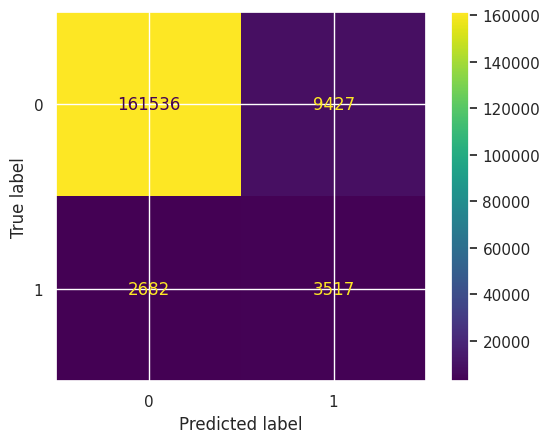

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.27      0.57      0.37      6199

    accuracy                           0.93    177162
   macro avg       0.63      0.76      0.67    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7561044932684763


In [173]:
DT, DT_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
RF
Доля верно угаданных объектов 0.9662004267280794


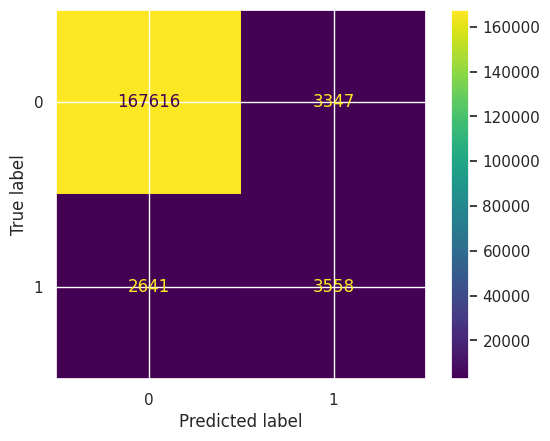

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.52      0.57      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.78      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9076374037293617


In [174]:
RF, RF_roc_auc = fit_pred_score(RandomForestClassifier(), 'RF', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7612637021483162


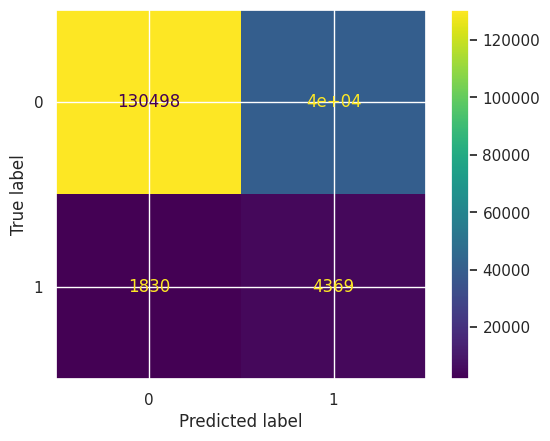

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    170963
           1       0.10      0.70      0.17      6199

    accuracy                           0.76    177162
   macro avg       0.54      0.73      0.52    177162
weighted avg       0.96      0.76      0.84    177162

roc auc score:  0.8057755623669836


In [175]:
AdaBoost, AdaBoost_roc_auc = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
GradBoost
Доля верно угаданных объектов 0.7777627256409388


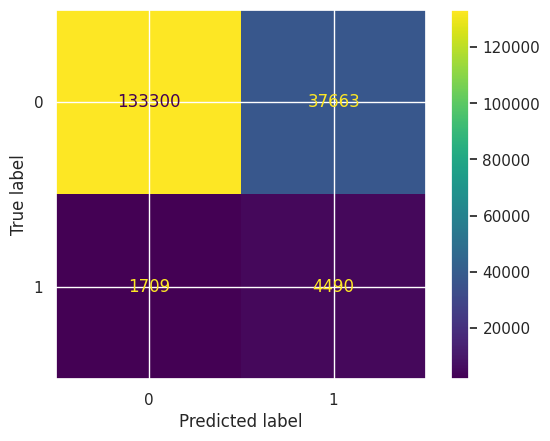

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.11      0.72      0.19      6199

    accuracy                           0.78    177162
   macro avg       0.55      0.75      0.53    177162
weighted avg       0.96      0.78      0.85    177162

roc auc score:  0.831122959707147


In [176]:
GradBoost, GradBoost_roc_auc = fit_pred_score(GradientBoostingClassifier(), 'GradBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8562332780167304


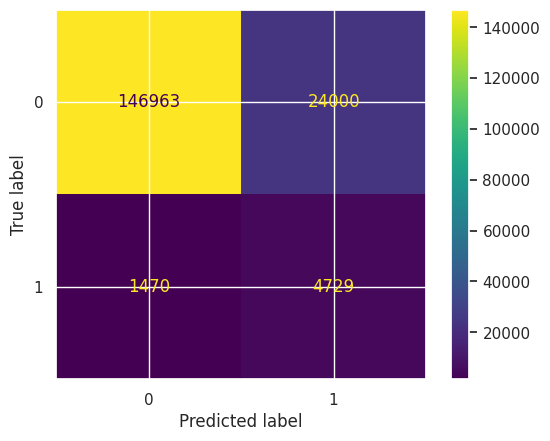

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    170963
           1       0.16      0.76      0.27      6199

    accuracy                           0.86    177162
   macro avg       0.58      0.81      0.60    177162
weighted avg       0.96      0.86      0.90    177162

roc auc score:  0.8900132384174425


In [177]:
XGB, XGB_roc_auc = fit_pred_score(XGBClassifier(), 'XGB', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8226030412842483


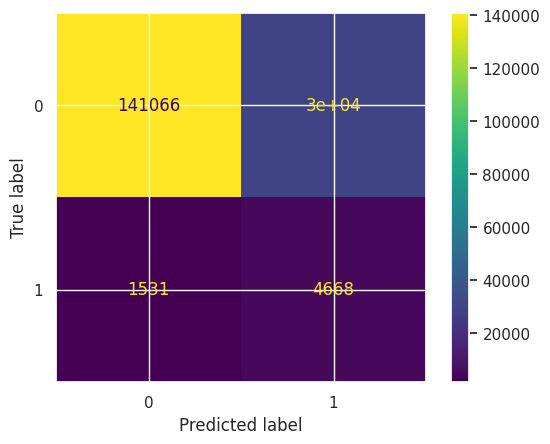

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    170963
           1       0.14      0.75      0.23      6199

    accuracy                           0.82    177162
   macro avg       0.56      0.79      0.56    177162
weighted avg       0.96      0.82      0.88    177162

roc auc score:  0.8677531152051149


In [178]:
LGBM, LGBM_roc_auc = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

Посмотрим и сравним оценки ```roc_auc``` до и после удаления не важных признаков

In [179]:
roc_auc_df2 = pd.DataFrame(data=[DT_roc_auc, 
                                 RF_roc_auc, 
                                 AdaBoost_roc_auc,
                                 GradBoost_roc_auc,
                                 XGB_roc_auc,
                                 LGBM_roc_auc],
                           index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc auc score2'])
roc_auc_general = pd.concat([roc_auc_df, roc_auc_df2], axis=1)
roc_auc_general

,roc auc score,roc auc score2
DT,0.754059,0.756104
RF,0.906790,0.907637
AdaBoost,0.807051,0.805776
GBM,0.831439,0.831123
XGB,0.890614,0.890013
LGBM,0.868807,0.867753


Теперь уберём выбросы из данных и затем снова приступим к обучению моделей

Снова посмотрим на распределения оставшихся признаков

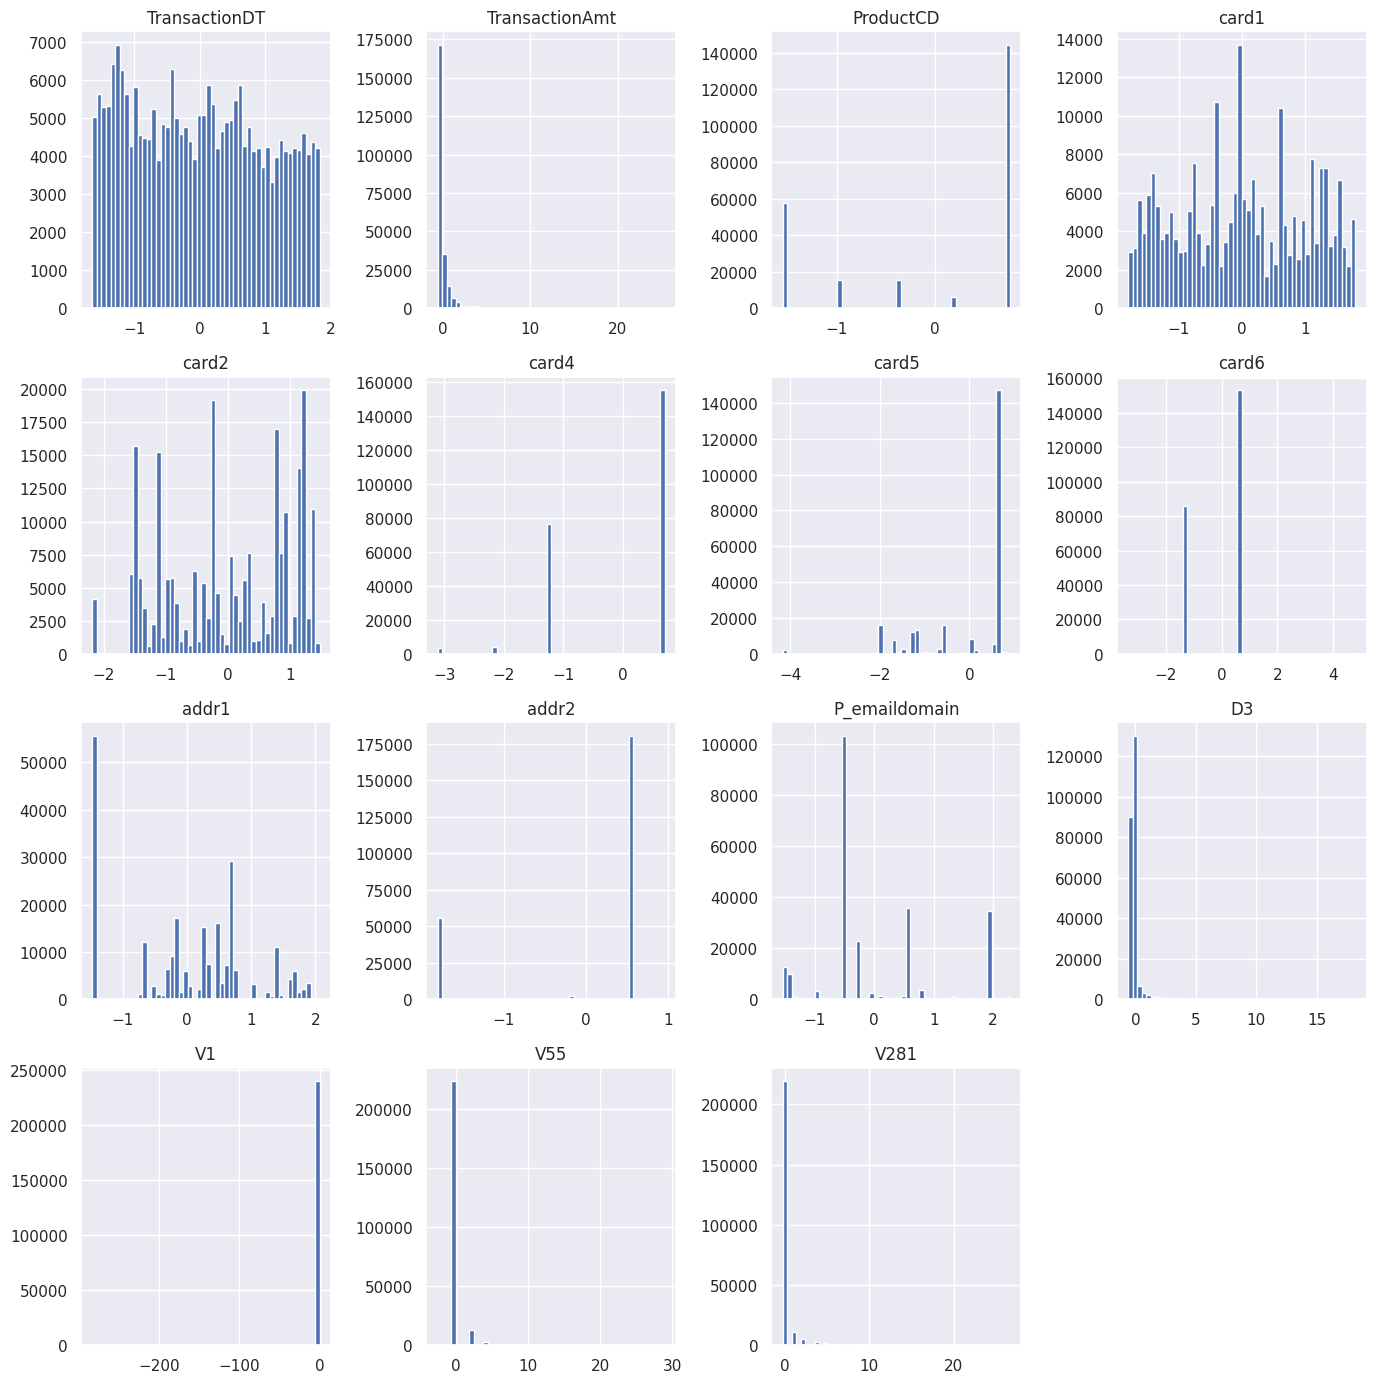

In [180]:
X_train_sc[X_train_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

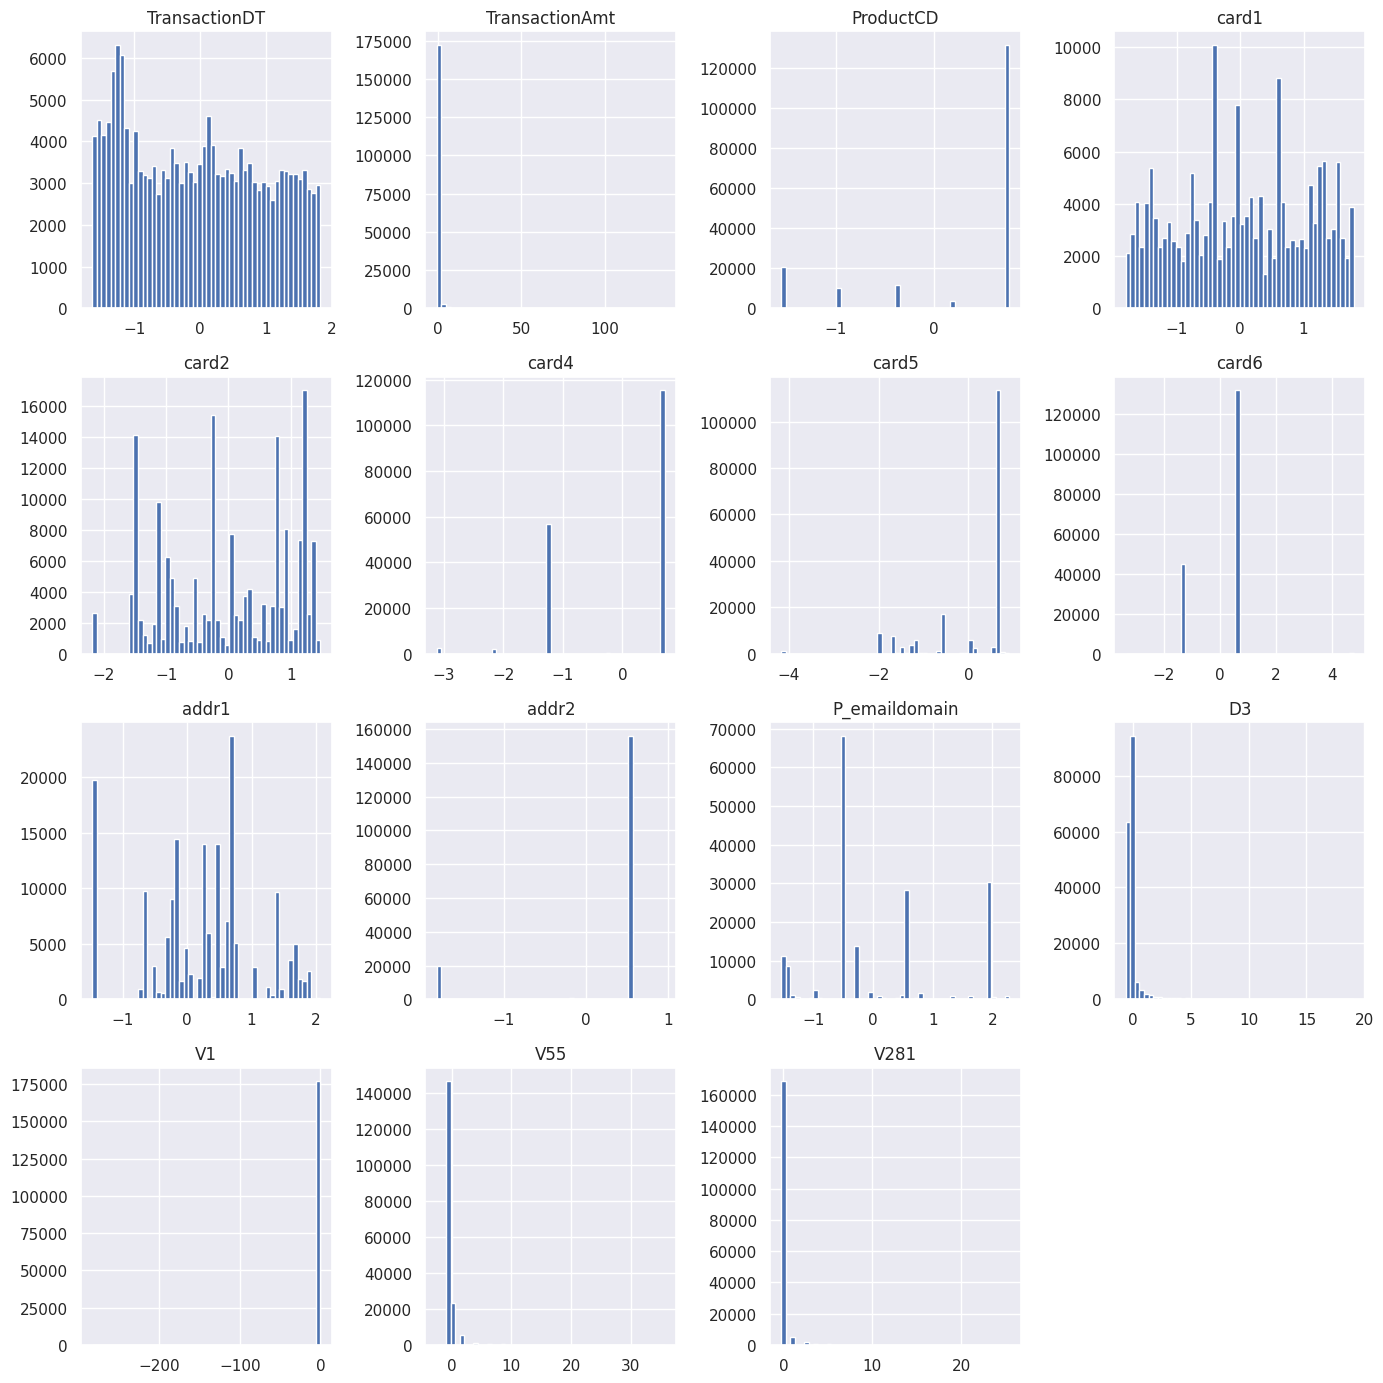

In [181]:
X_valid_sc[X_valid_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

А также на boxplotы

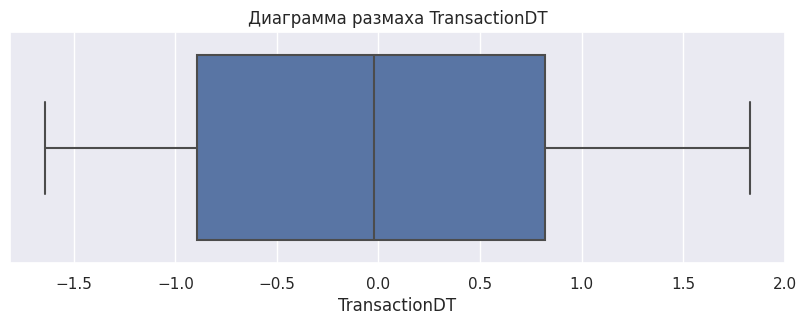

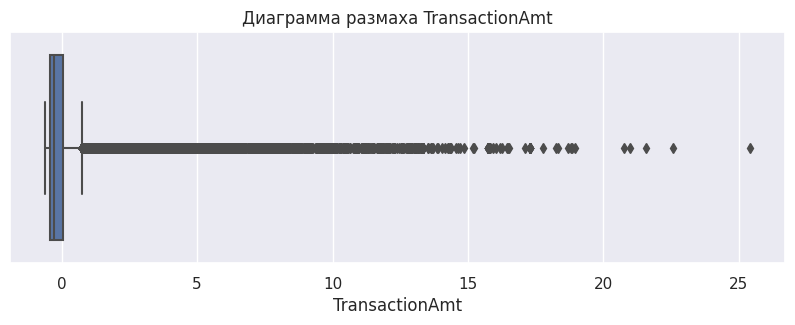

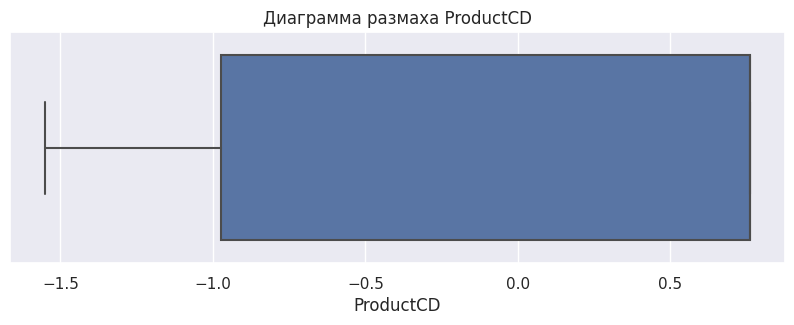

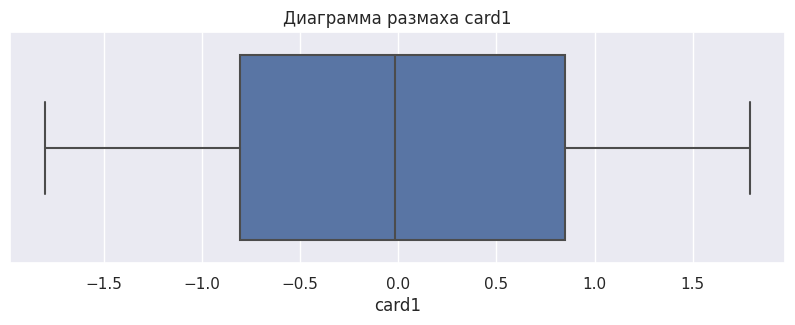

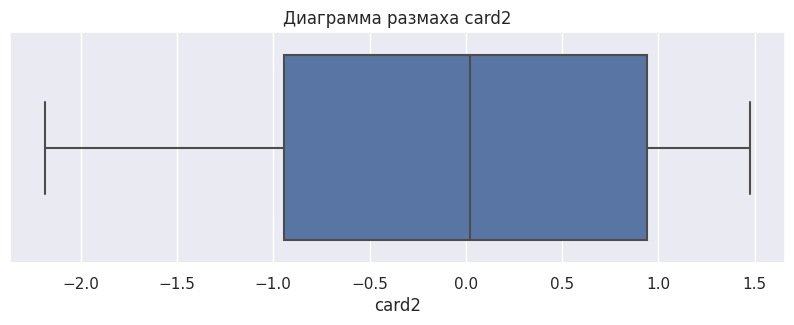

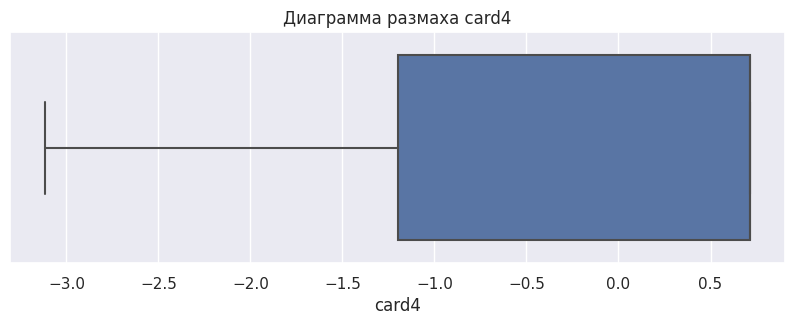

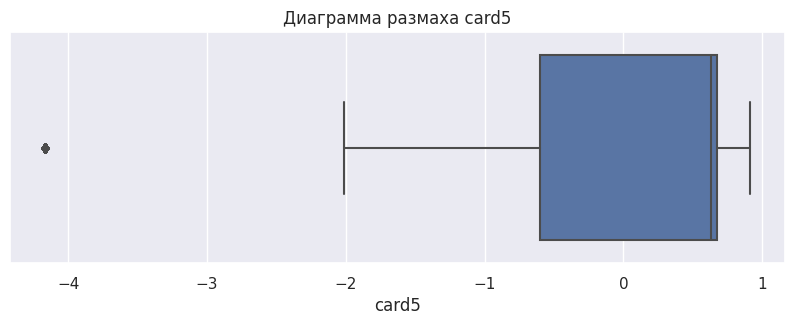

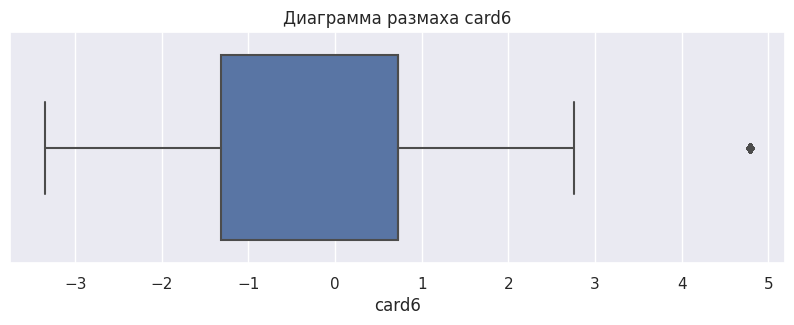

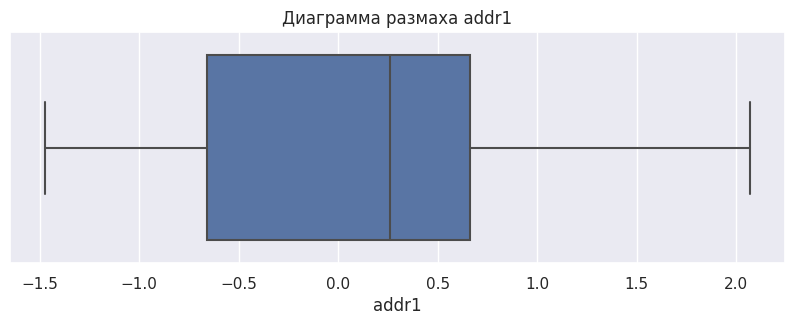

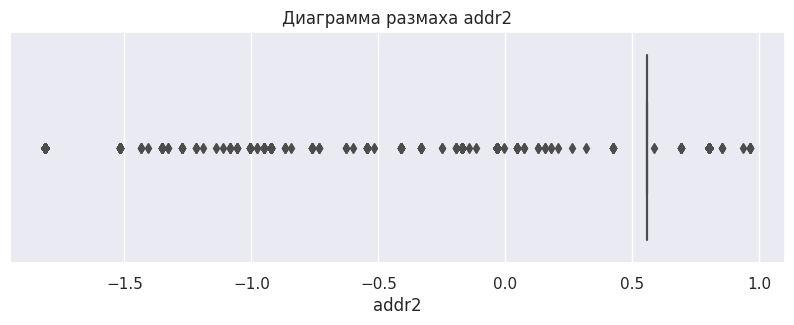

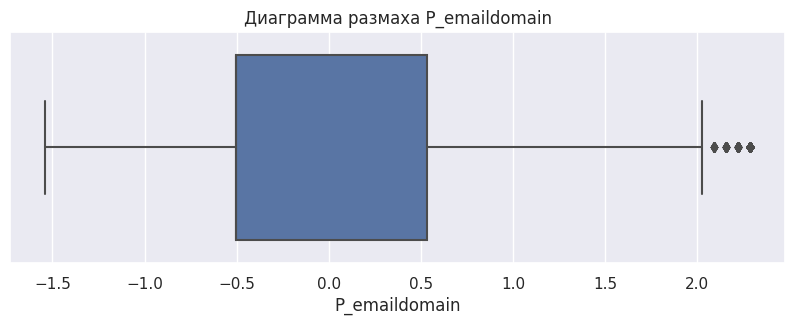

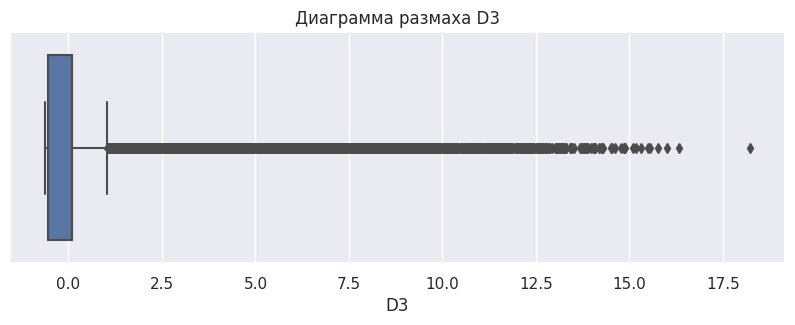

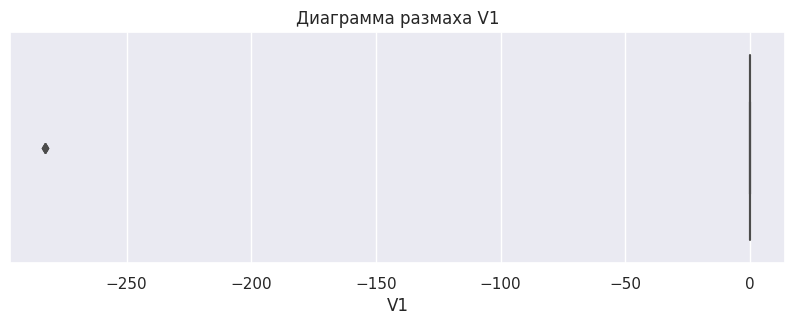

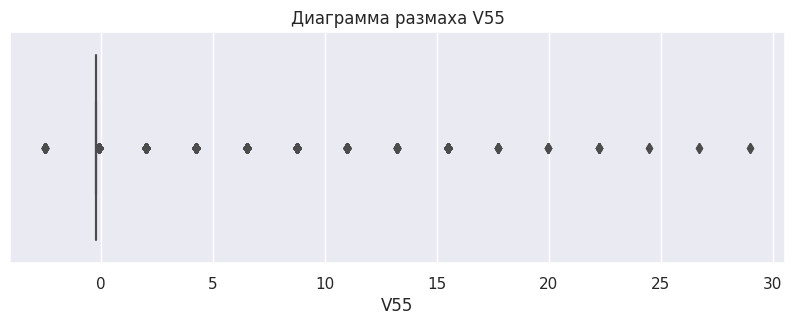

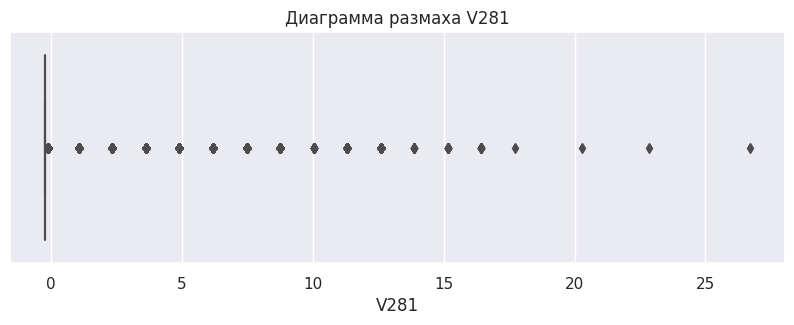

In [182]:
for feat in X_train_sc.columns:
    plt_boxplot(X_train_sc, feat)

Для валидационного датасета:

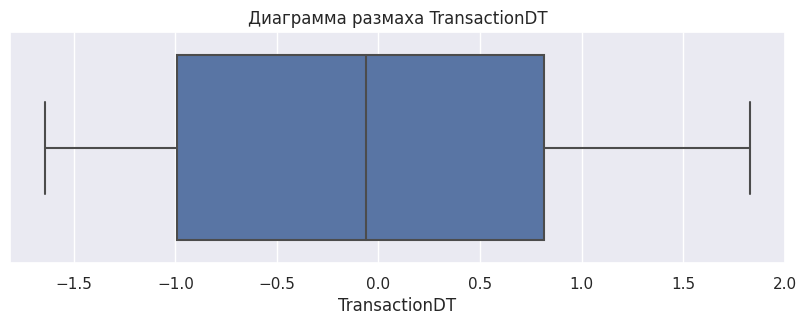

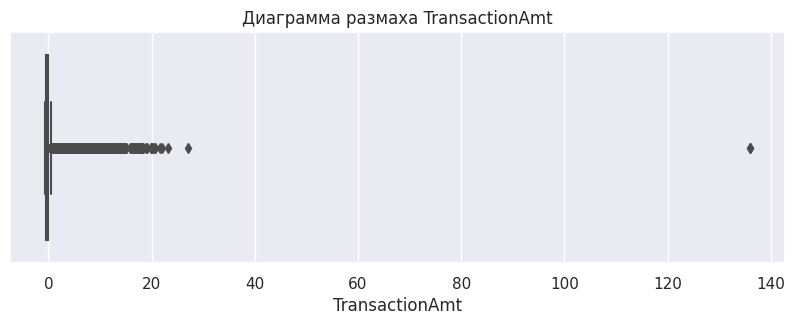

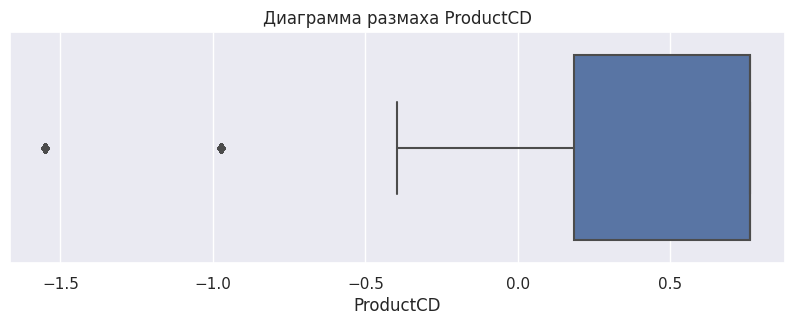

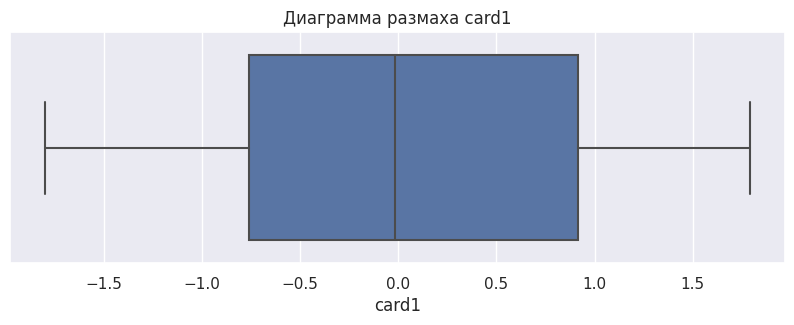

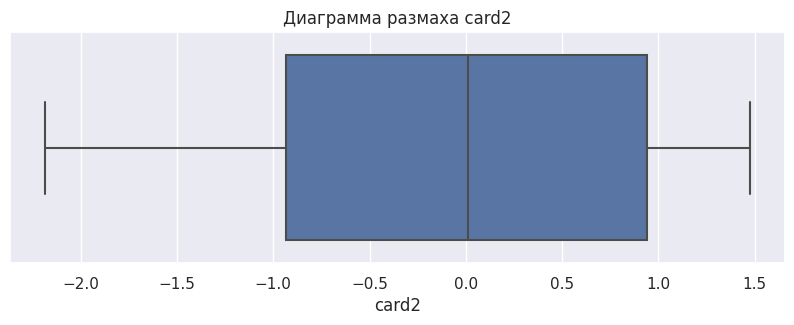

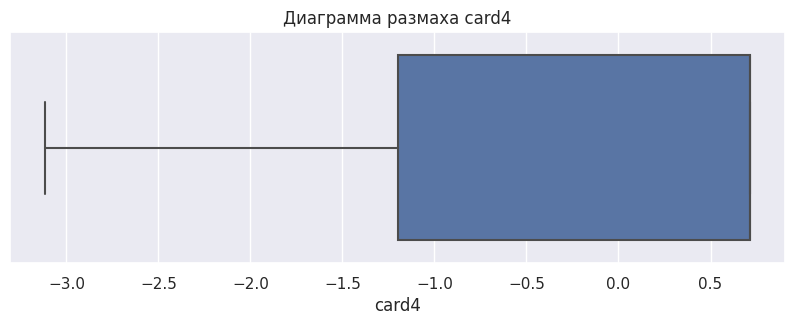

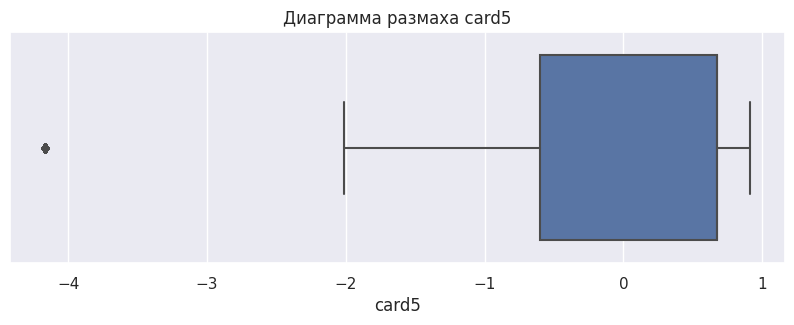

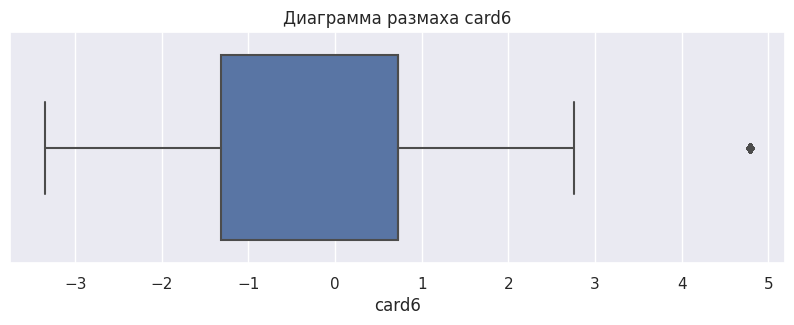

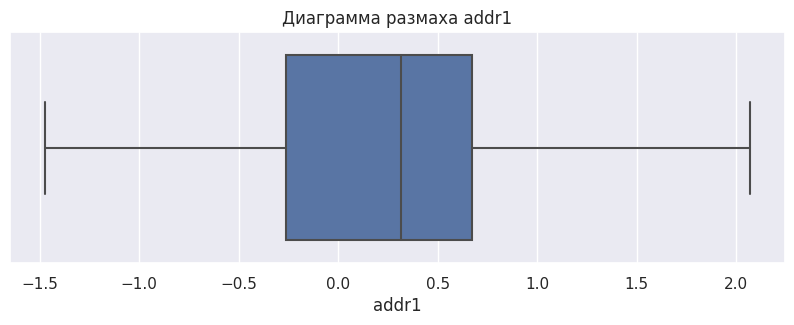

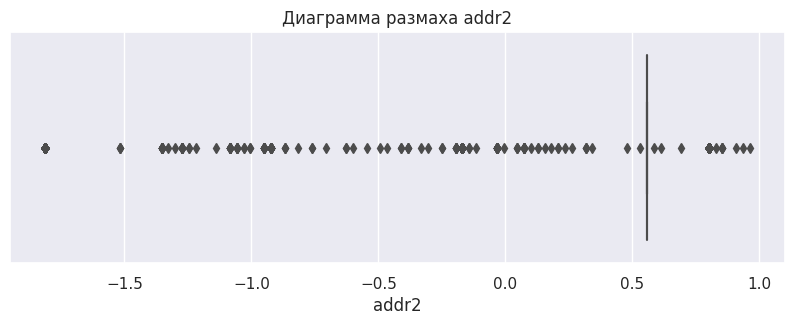

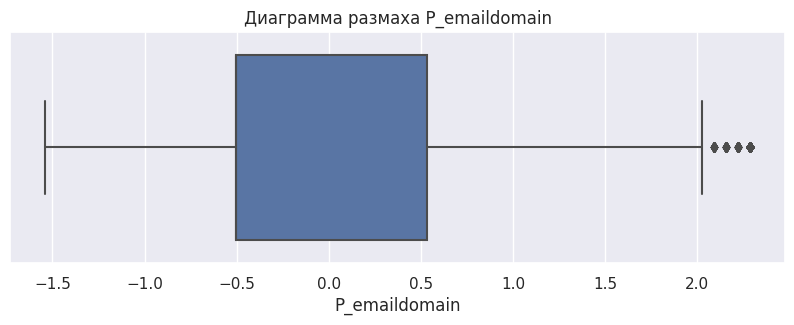

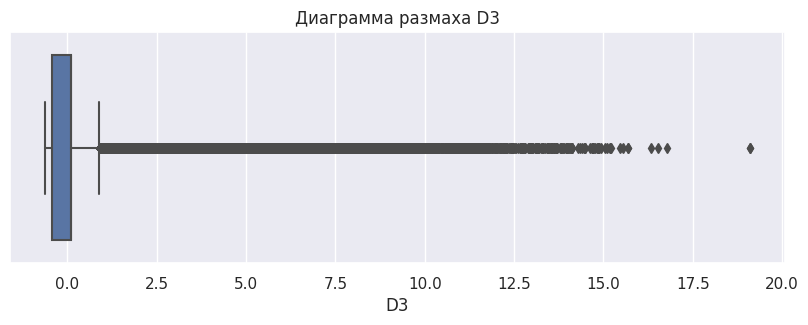

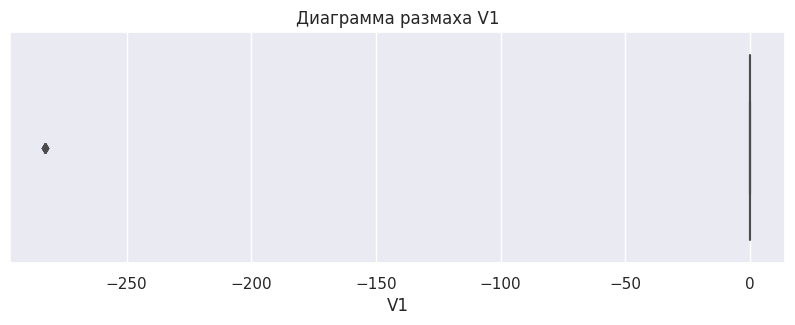

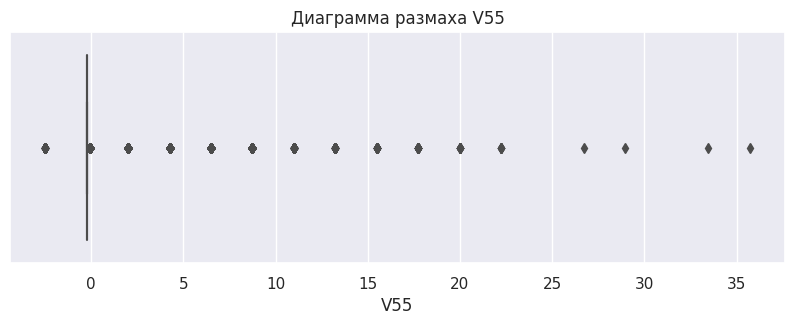

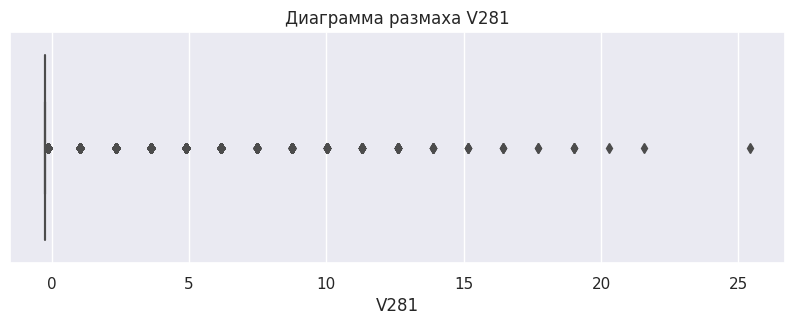

In [183]:
for feat in X_valid_sc.columns:
    plt_boxplot(X_valid_sc, feat)

Видим, что в признаках ```V1```, ```V55``` и ```V281``` очень много выбросов. Удалим эти признаки из данных

In [184]:
X_train_sc = X_train_sc.drop(columns=['V1', 'V55', 'V281'])
X_valid_sc = X_valid_sc.drop(columns=['V1', 'V55', 'V281'])

In [185]:
X_train_sc

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,D3
304425,0.001557,-0.272043,0.760398,1.192517,0.805496,0.713384,0.675672,0.720111,0.491376,0.558409,-1.409805,0.092514
297919,-0.038356,-0.440896,0.760398,-0.326406,-0.674456,0.713384,0.675672,-1.312608,-0.307087,0.558409,1.961594,-0.470653
521129,1.362474,-0.496597,0.760398,-0.044780,-0.223771,0.713384,0.675672,0.720111,-0.130378,0.558409,-0.502121,-0.244291
306940,0.020433,-0.376194,-1.550051,1.143001,0.105107,-1.200821,0.633008,0.720111,-1.472057,-1.811638,0.535233,-0.621560
111482,-1.181349,-0.180136,-0.394827,1.565749,1.201368,-3.115026,-4.166697,-1.312608,0.491376,0.558409,1.961594,0.092514
...,...,...,...,...,...,...,...,...,...,...,...,...
481000,1.099367,-0.107465,0.760398,0.728711,-1.502742,0.713384,0.675672,0.720111,1.793786,0.558409,1.961594,3.729610
3704,-1.625395,-0.564865,0.182785,-0.203234,0.013752,-1.200821,0.739669,0.720111,1.420733,0.558409,0.535233,0.092514
245,-1.640350,-0.449027,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-1.472057,-1.811638,-0.307617,0.092514
421535,0.696958,0.251616,0.760398,0.583256,-0.223771,0.713384,0.675672,0.720111,1.420733,0.558409,0.535233,-0.596409


In [186]:
X_valid_sc

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,D3
46589,-1.414956,-0.520612,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-0.614691,-0.168764,-0.307617,0.088501
392434,0.512114,0.358485,0.760398,1.541404,-0.223771,0.713384,0.675672,0.720111,0.262308,0.558409,-0.502121,0.088501
51673,-1.393220,-0.358894,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-1.472057,-1.811638,-0.307617,4.157182
512416,1.296843,-0.522117,-0.972439,0.955663,-1.143412,-1.200821,0.014380,-1.312608,-0.529609,0.558409,-0.502121,0.088501
452500,0.890063,-0.107465,0.760398,0.614410,0.805496,0.713384,0.675672,0.720111,0.661540,0.558409,-0.502121,-0.621560
...,...,...,...,...,...,...,...,...,...,...,...,...
131786,-1.084786,-0.353349,0.760398,1.020034,-0.899799,0.713384,0.675672,0.720111,0.779346,0.558409,-0.048278,0.088501
307735,0.030179,-0.235708,0.760398,0.614410,0.805496,0.713384,0.675672,0.720111,0.661540,0.558409,1.961594,0.088501
233592,-0.441047,-0.496682,0.760398,0.644120,-0.223771,0.713384,0.675672,0.720111,0.262308,0.558409,-0.502121,-0.395199
423709,0.704587,-0.231647,0.760398,0.614410,0.805496,0.713384,0.675672,0.720111,0.661540,0.558409,-0.502121,-0.093383


Напишем функцию для отбора данных от выбросов

In [187]:
def data_without_feat_emsns(df, feature):
    first_qrt = df[feature].describe()['25%']
    third_qrt = df[feature].describe()['75%']
    iqr = third_qrt - first_qrt
    
    condition = (df[feature] > (first_qrt - 3 * iqr)) & \
    (df[feature] < (third_qrt + 3 * iqr))
    
    df = df[condition]
    return df

In [188]:
for feat in X_train_sc.columns:
    X_train_sc = data_without_feat_emsns(X_train_sc, feat)

In [189]:
X_train_sc

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card4,card5,card6,addr1,addr2,P_emaildomain,D3
304425,0.001557,-0.272043,0.760398,1.192517,0.805496,0.713384,0.675672,0.720111,0.491376,0.558409,-1.409805,0.092514
297919,-0.038356,-0.440896,0.760398,-0.326406,-0.674456,0.713384,0.675672,-1.312608,-0.307087,0.558409,1.961594,-0.470653
521129,1.362474,-0.496597,0.760398,-0.044780,-0.223771,0.713384,0.675672,0.720111,-0.130378,0.558409,-0.502121,-0.244291
306940,0.020433,-0.376194,-1.550051,1.143001,0.105107,-1.200821,0.633008,0.720111,-1.472057,-1.811638,0.535233,-0.621560
111482,-1.181349,-0.180136,-0.394827,1.565749,1.201368,-3.115026,-4.166697,-1.312608,0.491376,0.558409,1.961594,0.092514
...,...,...,...,...,...,...,...,...,...,...,...,...
212143,-0.574654,0.554910,0.760398,-0.030751,1.371897,0.713384,0.675672,-1.312608,0.550278,0.558409,0.535233,0.092514
3704,-1.625395,-0.564865,0.182785,-0.203234,0.013752,-1.200821,0.739669,0.720111,1.420733,0.558409,0.535233,0.092514
245,-1.640350,-0.449027,-1.550051,0.762548,-1.551465,0.713384,-1.222878,-1.312608,-1.472057,-1.811638,-0.307617,0.092514
421535,0.696958,0.251616,0.760398,0.583256,-0.223771,0.713384,0.675672,0.720111,1.420733,0.558409,0.535233,-0.596409


Посмотрим на распределения данных и boxplotы после очистки данных от выбросов

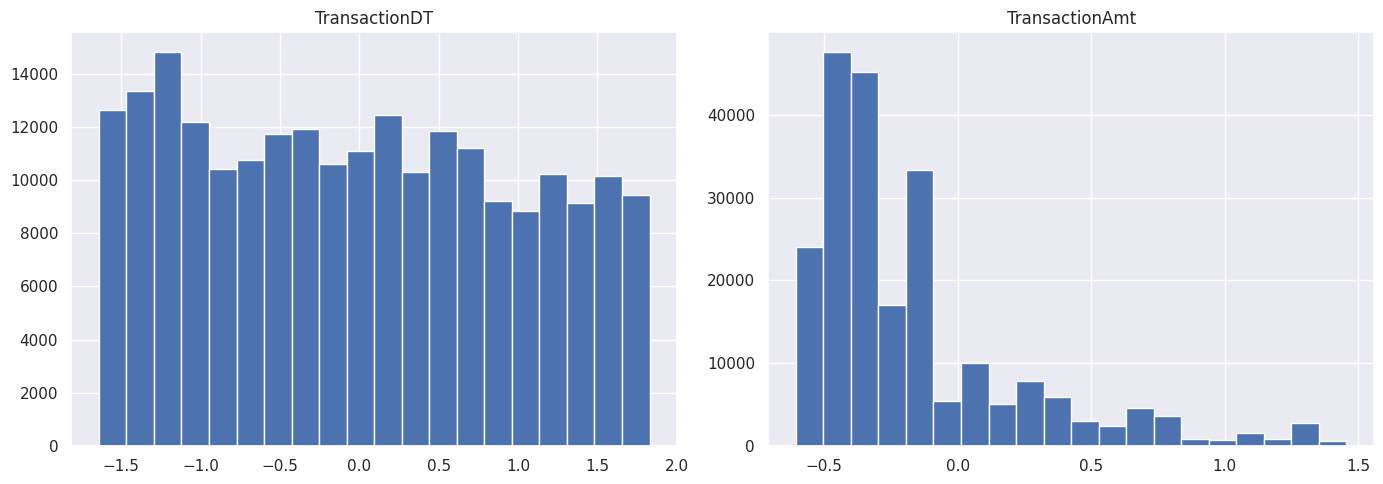

In [190]:
X_train_sc[['TransactionDT','TransactionAmt']].hist(bins=20, figsize=(14,5))
plt.tight_layout()

Видим, что распределения числовых признаков ```TransactionDT``` и ```TransactionAmt``` очищены от выбросов

In [191]:
X_valid_sc = data_without_feat_emsns(X_valid_sc, 'TransactionDT')

In [192]:
X_valid_sc = data_without_feat_emsns(X_valid_sc, 'TransactionAmt')

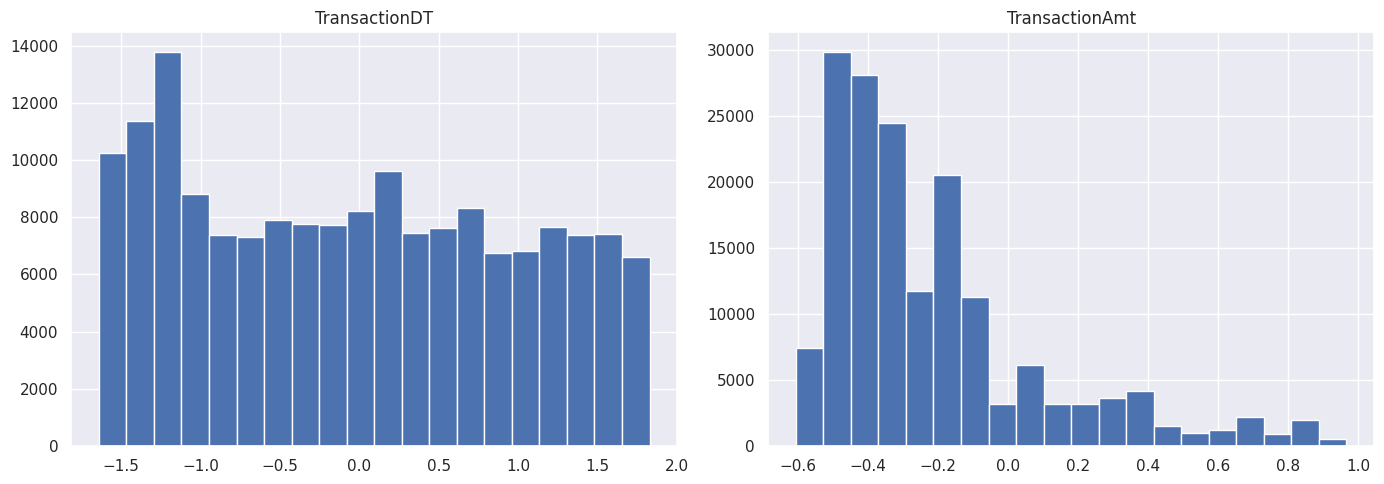

In [193]:
X_valid_sc[['TransactionDT','TransactionAmt']].hist(bins=20, figsize=(14,5))
plt.tight_layout()

#### Снова приступим к обучению моделей

In [194]:
y_train_balanced.loc[list(X_train_sc.index)]

304425    0
297919    0
521129    0
306940    0
111482    0
         ..
338008    1
338008    1
338008    1
338008    1
338008    1
Name: isFraud, Length: 975314, dtype: uint8